In [1]:
import os
import pickle
from tqdm import tqdm
import itertools

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)

import matplotlib.font_manager as fm
from matplotlib import rc
import matplotlib.pyplot as plt
plt.rc('font', family = 'Malgun Gothic')
plt.rc('axes', unicode_minus=False)

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import ols

import warnings
warnings.filterwarnings('ignore')

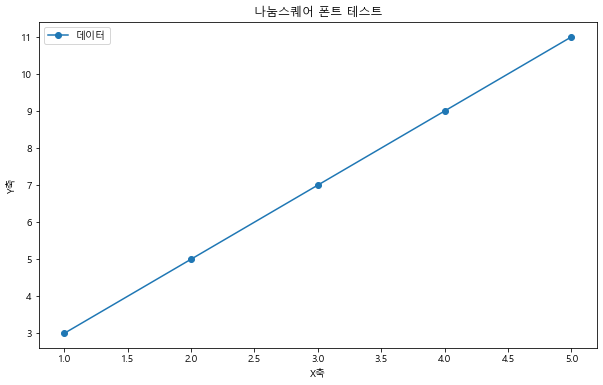

In [2]:
x = [1, 2, 3, 4, 5]
y = [3, 5, 7, 9, 11]

plt.figure(figsize=(10,6))
plt.plot(x, y, 'o-', label="데이터")
plt.title("맑은 고딕 폰트 테스트")
plt.xlabel("X축")
plt.ylabel("Y축")
plt.legend()
plt.show()

In [3]:
raw_file = "./data/purchase_transaction_data.csv"
raw = pd.read_csv(raw_file)
raw[['Category1', 'Category2', 'Category3', 'Category4', 'Category5']] = raw['MasterCategoryFullName'].str.split('-', expand=True)
raw.loc[(raw['Category1'] == '주류') & (raw['Category2'] == ''), 'Category2'] = '주류'
raw["Sales"] = raw["Price"] * raw["SalesUnit"]
raw

,id,OrderId,PersonId,PurchaseDate,ItemDescription,SalesUnit,Price,ProductCode,MasterCategoryFullName,Agegroup,Gender,Retailer,Category1,Category2,Category3,Category4,Category5,Sales
0,2,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,대림 오양맛살270g,1,1480,8801088106118,가공식품-어육/연식품류-어육제품류-맛살,36,F,A,가공식품,어육/연식품류,어육제품류,맛살,None,1480
1,8,2021010108138430000000,168586e3815732f18f68ddef204819c7,2021-01-01,풀무원 김치뚝배기 우동 (2인),1,6180,8801114147252,가공식품-즉석/편의식품-즉석/조리식품-즉석면류,36,M,B,가공식품,즉석/편의식품,즉석/조리식품,즉석면류,None,6180
2,9,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,CJ백설소갈비양념500g,1,2580,8801007176352,가공식품-조미료-드레싱/소스-소스,36,F,A,가공식품,조미료,드레싱/소스,소스,None,2580
3,11,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,샘표맛간장조림볶음용,2,8880,8801005104067,가공식품-조미료-장류-간장,36,F,A,가공식품,조미료,장류,간장,None,17760
4,13,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,샘표맛간장국찌개1.8L,1,8900,8801005110228,가공식품-조미료-장류-간장,36,F,A,가공식품,조미료,장류,간장,None,8900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118804,390581,2021040306718280000000,eea4022e52f88e47e002bf9533aded5c,2021-04-03,빙그레 요플레 클래식,1,2800,8801104280037,가공식품-유제품-요구르트-기타요구르트,40,F,A,가공식품,유제품,요구르트,기타요구르트,None,2800
118805,390584,2021022700263890000000,eea4022e52f88e47e002bf9533aded5c,2021-02-27,풀무원 자연은맛있다,1,4980,8801114150450,가공식품-즉석/편의식품-라면류-봉지라면,40,F,A,가공식품,즉석/편의식품,라면류,봉지라면,None,4980
118806,390586,2023062500967460000000,22aca1bdf92346d1fbd589fd72622957,2023-06-25,딸기잼800g,1,5880,8809306211033,가공식품-통조림/병-농산물통조림/병-잼류/스프레드류,44,M,A,가공식품,통조림/병,농산물통조림/병,잼류/스프레드류,None,5880
118807,390588,2023062905029460000000,5957cbf9d746b210eedc703ea368a00e,2023-06-29,왓따산리오캐릭터즈13,2,500,8801062874781,가공식품-과자류-사탕류-껌류,36,F,A,가공식품,과자류,사탕류,껌류,None,1000


# 1. 주류 구매건 vs 비구매건 평균 구매액 차이 검증

OrderId 분석
- OrderId 中 주류 구매건 분석 : 주류+기타 상품 구매 80.8% & 주류만 구매 19.2%

-> 주류+기타 상품 구매건 中
- (주류 구매건) vs (주류 구매자_주류 비구매건) vs (주류 비구매자) 차이 검증
- One-Way ANOVA + Bonferroni 사후검정 (결과는 하단 참조.)


In [4]:
# 주류 구매자 PersonID
liquor_df = raw[raw.Category2 == '주류']
liquor_ids = list(np.unique(liquor_df["PersonId"]))

# 주류 구매자 중 주류 구매건 vs 주류 비구매건
liquor_exp = raw[raw.PersonId.isin(liquor_ids)]
liquor_exp_df = liquor_exp[liquor_exp.Category2 == "주류"]

### -> 주류 구매 경험자중 주류 구매건 OrderID & 주류 비구매 OrderID
liquor_exp_order = list(np.unique(liquor_exp_df.OrderId))
liquor_exp_norder = [id for id in np.unique(liquor_exp.OrderId) if id not in liquor_exp_order]

# 주류 비구매 PersonID
all_ids = np.unique(raw.PersonId)
nliquor_ids = [id for id in all_ids if id not in liquor_ids]
# 주류 비구매자의 OrderID : liquor_nexp_norder
liquor_nexp = raw[raw.PersonId.isin(nliquor_ids)]
liquor_nexp_norder = np.unique(liquor_nexp.OrderId).tolist()

### ===> liquor_exp_order vs liquor_exp_norder vs liquor_nexp_norder

In [5]:
liquor_exp_order_df = raw[raw.OrderId.isin(liquor_exp_order)]
liquor_exp_norder_df = raw[raw.OrderId.isin(liquor_exp_norder)]
liquor_nexp_norder_df = raw[raw.OrderId.isin(liquor_nexp_norder)]

In [6]:
exp_order_grp = liquor_exp_order_df.groupby(["OrderId", "Category2"])["Sales"].sum().unstack(fill_value = np.nan)
exp_order_grp["Sales"] = liquor_exp_order_df.groupby("OrderId")["Sales"].sum()
exp_order_grp["Sales_w/o_Liquor"] = exp_order_grp["Sales"] - exp_order_grp["주류"]
exp_order_grp

Category2,,가공식품류,가공식품선물세트류,가공식품세트류,건강식품,공구,"과자,씨리얼,초코릿,빵","과자,씨리얼,초코릿,빵류",과자류,구강용품,...,"축산,수산,건해산",축산가공식품,캠핑,커피/코코아,통조림/병,"헤어,바디,구강",화장지류,화장품,Sales,Sales_w/o_Liquor
OrderId,,,,,,,,,,,,,,,,,,,,,
2021010100980400000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33000,0.0
2021010101472360000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11270,3050.0
2021010103031800000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6480,0.0
2021010103159690000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4980.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53610,38850.0
2021010103252220000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,980.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2860,980.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023062300572320000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33580,14460.0
2023062407514950000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9320,4480.0
2023062409741000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3340.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88890,33610.0


In [7]:
exp_norder_grp = liquor_exp_norder_df.groupby(["OrderId", "Category2"])["Sales"].sum().unstack(fill_value = np.nan)
exp_norder_grp["Sales"] = liquor_exp_norder_df.groupby("OrderId")["Sales"].sum()
exp_norder_grp

Category2,,DIY용품,가공식품류,가공식품선물세트류,가공식품세트류,건강식품,공구,"과자,씨리얼,초코릿,빵","과자,씨리얼,초코릿,빵류",과자류,...,축산가공식품,카레·스프류,캠핑,"커피,차류",커피/코코아,통조림/병,"헤어,바디,구강",화장지류,화장품,Sales
OrderId,,,,,,,,,,,,,,,,,,,,,
2021010100727260000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12200
2021010101077510000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3920.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10400
2021010101283050000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1200.0,...,4260.0,NaN,NaN,NaN,3280.0,NaN,NaN,NaN,NaN,27330
2021010101337940000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21410
2021010101510940000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7140.0,...,5580.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023063000798260000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1700
2023063001646400000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5940.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33980
2023063003354460000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13460.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20420


In [8]:
nexp_norder_grp = liquor_nexp_norder_df.groupby(["OrderId", "Category2"])["Sales"].sum().unstack(fill_value = np.nan)
nexp_norder_grp["Sales"] = liquor_nexp_norder_df.groupby("OrderId")["Sales"].sum()
nexp_norder_grp

Category2,,DIY용품,가공식품류,가공식품선물세트류,가공식품세트류,건강식품,공구,"과자,씨리얼,초코릿,빵","과자,씨리얼,초코릿,빵류",과자류,...,축산물,카레·스프류,캠핑,"커피,차류",커피/코코아,통조림/병,"헤어,바디,구강",화장지류,화장품,Sales
OrderId,,,,,,,,,,,,,,,,,,,,,
2021010100210090000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1980
2021010100258590000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3400
2021010100348250000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1980
2021010100408850000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11340.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12920
2021010100681820000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4780.0,...,NaN,NaN,NaN,NaN,NaN,6230.0,NaN,NaN,NaN,32410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023062709513530000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5560
2023062809761970000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19960
2023062900089940000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6480


In [9]:
grp1 = exp_order_grp["Sales_w/o_Liquor"].dropna()
grp2 = exp_norder_grp["Sales"].dropna()
grp3 = nexp_norder_grp["Sales"].dropna()

전체 구매건 3982
주류만 구매 - 779, (19.6%)
주류 外 구매 - 3203, (80.4%)


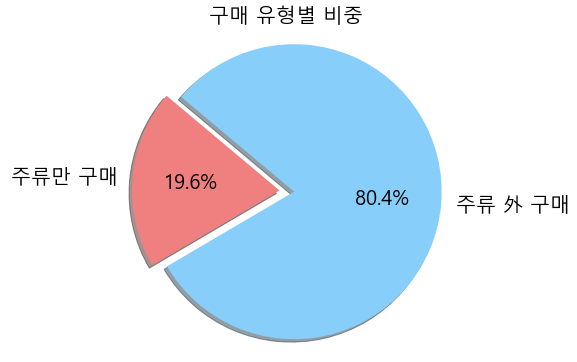

In [10]:
total_ids = len(np.unique(grp1.index))
print("전체 구매건", total_ids)

liq_only_orders = grp1[grp1 == 0].index
liq_only_len = len(np.unique(raw[raw.OrderId.isin(liq_only_orders)].OrderId))
print(f"주류만 구매 - {liq_only_len}, ({liq_only_len/total_ids*100:.1f}%)")

liq_plus_orders = grp1[grp1 > 0].index
liq_plus_len = len(np.unique(raw[raw.OrderId.isin(liq_plus_orders)].OrderId))
print(f"주류 外 구매 - {liq_plus_len}, ({liq_plus_len/total_ids*100:.1f}%)")

labels = ['주류만 구매', '주류 外 구매']
sizes = [liq_only_len, liq_plus_len]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # 첫 번째 조각은 빼내어 강조

# 파이 차트 그리기
plt.figure(figsize=(10, 6), facecolor='white')  # 배경색을 하얀색으로 설정
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140, textprops={'fontsize': 20})

plt.axis('equal')  # 파이 차트를 원형으로 보이게 함
plt.title("구매 유형별 비중", fontsize=20)
plt.show()

Shapiro-Wilk Test for grp1: statistic = 0.354, p-value = 0.000
Shapiro-Wilk Test for grp2: statistic = 0.613, p-value = 0.000
Shapiro-Wilk Test for grp3: statistic = 0.157, p-value = 0.000


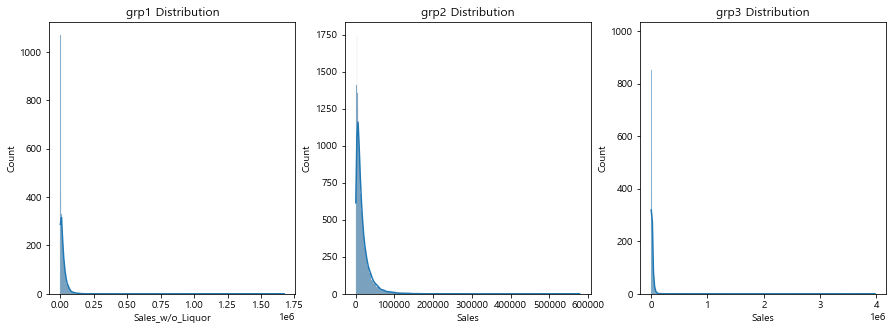

In [11]:
# 정규성 검정
shapiro_grp1 = stats.shapiro(grp1)
shapiro_grp2 = stats.shapiro(grp2)
shapiro_grp3 = stats.shapiro(grp3)

print(f"Shapiro-Wilk Test for grp1: statistic = {shapiro_grp1[0]:.3f}, p-value = {shapiro_grp1[1]:.3f}")
print(f"Shapiro-Wilk Test for grp2: statistic = {shapiro_grp2[0]:.3f}, p-value = {shapiro_grp2[1]:.3f}")
print(f"Shapiro-Wilk Test for grp3: statistic = {shapiro_grp3[0]:.3f}, p-value = {shapiro_grp3[1]:.3f}")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(grp1, kde=True)
plt.title('grp1 Distribution')

plt.subplot(1, 3, 2)
sns.histplot(grp2, kde=True)
plt.title('grp2 Distribution')

plt.subplot(1, 3, 3)
sns.histplot(grp3, kde=True)
plt.title('grp3 Distribution')

plt.show()

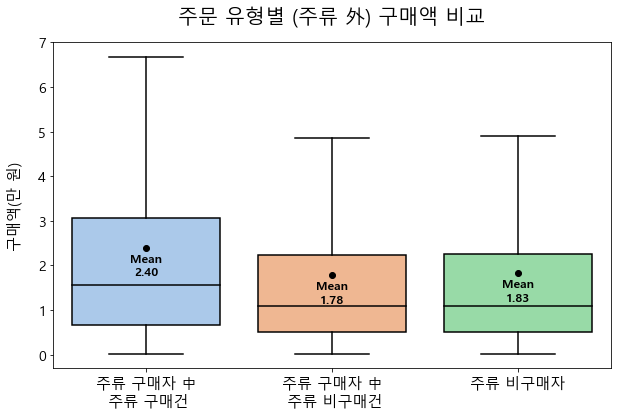

In [12]:
grp1 = grp1[grp1 > 0]

data = [grp1, grp2, grp3]
labels = ['주류 구매자 中\n 주류 구매건', '주류 구매자 中\n 주류 비구매건', '주류 비구매자']

data_million_units = [group/10000 for group in data]

plt.figure(figsize=(10, 6), facecolor='white')
bp = sns.boxplot(data=data_million_units, showfliers=False, palette="pastel")  # 이상치를 표시하지 않음

for line in bp.lines:
    if line.get_ydata().size == 2:  # median 선은 y 데이터 포인트가 2개인 선입니다.
        line.set_color('black')

# 박스 플롯의 박스 테두리 색상을 검정색으로 변경
for box in bp.patches:
    box.set_edgecolor('black')

means = [group.mean() for group in data_million_units]
for i, mean in enumerate(means):
    plt.plot(i, mean, marker='o', color='black', markersize=6)
    plt.text(i, mean -0.4, f"Mean\n{mean:.2f}", ha='center', fontweight = "bold", va='center', fontsize=12)

plt.xticks(ticks=range(3), labels=labels, fontsize = 15)
plt.yticks(fontsize = 14)

plt.title('주문 유형별 (주류 外) 구매액 비교', fontsize = 20, pad = 20)
plt.ylabel('구매액(만 원)', fontsize = 15, labelpad = 15)
plt.show()

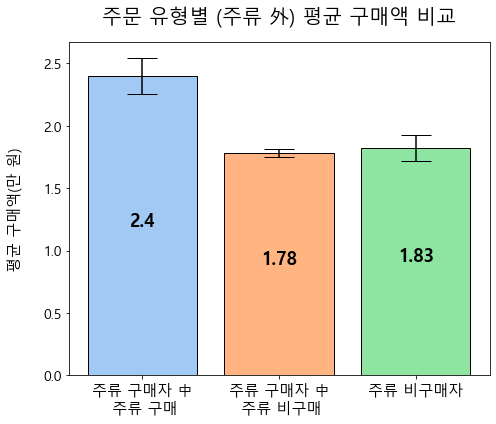

In [13]:
def confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    mean, std_err = np.mean(a), np.std(a)/np.sqrt(n)
    interval = std_err * stats.t.ppf((1 + confidence) / 2., n-1)
    return mean, interval

# grp1, grp2, grp3에 대한 평균과 95% 신뢰구간을 계산
mean1, h1 = confidence_interval(grp1)
mean2, h2 = confidence_interval(grp2)
mean3, h3 = confidence_interval(grp3)

means = np.array([mean1, mean2, mean3])/10000
errors = np.array([h1, h2, h3])/10000
labels = ['주류 구매자 中\n 주류 구매', '주류 구매자 中\n 주류 비구매', '주류 비구매자']

plt.figure(figsize=(7, 6), facecolor='white')
palette_colors = sns.color_palette("pastel", 3)
bars = plt.bar(labels, means, yerr=errors, capsize=15, color=palette_colors, edgecolor='black')  # error_kw 파라미터 추가

plt.ylabel('평균 구매액(만 원)', fontsize=15, labelpad = 20)
plt.title('주문 유형별 (주류 外) 평균 구매액 비교', fontsize=20, pad = 20)
plt.xticks(fontsize=15)
plt.yticks(np.arange(0, max(means)+0.2, 0.5), fontsize=14)  # y축 간격을 적게 표시

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height/2, round(height, 2), ha='center', fontsize=18, fontweight = "bold")

plt.tight_layout()
plt.show()

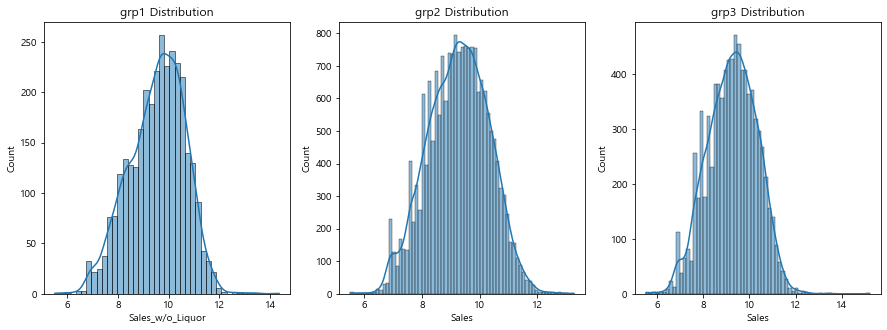

Shapiro-Wilk Test for grp1: statistic = 0.990, p-value = 0.000
Shapiro-Wilk Test for grp2: statistic = 0.997, p-value = 0.000
Shapiro-Wilk Test for grp3: statistic = 0.996, p-value = 0.000


In [14]:
# 데이터 추가 처리 => grp1 주류 외 구매 0원인 case 제외 + transform 적용
grp1 = np.log(grp1)
grp2 = np.log(grp2)
grp3 = np.log(grp3)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(grp1, kde=True)
plt.title('grp1 Distribution')

plt.subplot(1, 3, 2)
sns.histplot(grp2, kde=True)
plt.title('grp2 Distribution')

plt.subplot(1, 3, 3)
sns.histplot(grp3, kde=True)
plt.title('grp3 Distribution')

plt.show()

shapiro_grp1 = stats.shapiro(grp1)
shapiro_grp2 = stats.shapiro(grp2)
shapiro_grp3 = stats.shapiro(grp3)

print(f"Shapiro-Wilk Test for grp1: statistic = {shapiro_grp1[0]:.3f}, p-value = {shapiro_grp1[1]:.3f}")
print(f"Shapiro-Wilk Test for grp2: statistic = {shapiro_grp2[0]:.3f}, p-value = {shapiro_grp2[1]:.3f}")
print(f"Shapiro-Wilk Test for grp3: statistic = {shapiro_grp3[0]:.3f}, p-value = {shapiro_grp3[1]:.3f}")


In [15]:
# 등분산성 검정
levene_test = stats.levene(grp1, grp2, grp3)
print(f"Levene's Test: statistic = {levene_test[0]:.3f}, p-value = {levene_test[1]:.3f}\n")

print(f"grp1({np.mean(grp1):.3f}) vs grp2({np.mean(grp2):.3f}) vs grp3({np.mean(grp3):.3f})\n")

# 데이터 결합
data4anova = pd.DataFrame({
    'group': ['grp1']*len(grp1) + ['grp2']*len(grp2) + ['grp3']*len(grp3),
    'sales': grp1.tolist() + grp2.tolist() + grp3.tolist()
})

# OLS 모델 적합
model = ols('sales ~ C(group)', data = data4anova).fit()

# Welch's ANOVA 수행
anova_table = sm.stats.anova_lm(model, typ=2)

# partial eta squre
ss_between = anova_table["sum_sq"]["C(group)"]
ss_total = model.ssr + ss_between
partial_eta_squared = ss_between / ss_total

anova_table["Partial Eta Squared"] = partial_eta_squared
print(anova_table)

# APA Style 결과 출력
f_stat = anova_table["F"]["C(group)"]
p_value = anova_table["PR(>F)"]["C(group)"]
print()

if p_value < 0.05:
    print(f"F({anova_table['df']['C(group)']:.0f}, {model.df_resid:.0f}) = {f_stat:.3f}, p = {p_value}, partial η^2 = {partial_eta_squared:.3f}")
else:
    print(f"F({anova_table['df']['C(group)']:.0f}, {model.df_resid:.0f}) = {f_stat:.3f}, p > .05, partial η^2 = {partial_eta_squared:.3f}")

Levene's Test: statistic = 1.396, p-value = 0.248

grp1(9.542) vs grp2(9.260) vs grp3(9.261)

                sum_sq       df           F        PR(>F)  Partial Eta Squared
C(group)    227.451211      2.0  101.816806  8.456823e-45             0.006575
Residual  34366.717680  30768.0         NaN           NaN             0.006575

F(2, 30768) = 101.817, p = 8.456823421923639e-45, partial η^2 = 0.007


In [16]:
import pingouin as pg

# Bonferroni-corrected pairwise T-tests
posthoc_bonf = pg.pairwise_ttests(data=data4anova, dv='sales', between='group', padjust='bonf')
print(posthoc_bonf)

  Contrast     A     B  Paired  Parametric          T           dof  \
0    group  grp1  grp2   False        True  13.668452   4270.022063   
1    group  grp1  grp3   False        True  12.542206   5649.742763   
2    group  grp2  grp3   False        True  -0.100468  16002.769077   

  alternative         p-unc        p-corr p-adjust       BF10    hedges  
0   two-sided  1.166184e-41  3.498552e-41     bonf  4.784e+38  0.266743  
1   two-sided  1.302942e-35  3.908827e-35     bonf  1.765e+32  0.263537  
2   two-sided  9.199744e-01  1.000000e+00     bonf      0.015 -0.001316  


일원분산분석(ANOVA)을 통해 그룹 간의 평균 차이를 검증한 결과, 그룹 간에 유의한 차이가 있음을 확인하였습니다.
$[ F(2, 30768) = 101.817, p < .001 ]$

사후검정은 본페로니 교정을 통해 수행되었습니다.

- **grp1 vs grp2:** 유의한 차이가 있었습니다.
  $[ t(4270.02) = 13.668, p < .001, \text{hedges' } g = 0.267 ]$
  
- **grp1 vs grp3:** 유의한 차이가 확인되었습니다.
  $[ t(5649.74) = 12.542, p < .001, \text{hedges' } g = 0.264 ]$

- **grp2 vs grp3:** 유의한 차이가 없었습니다.
  $[ t(16002.77) = -0.100, p = .920 ]$

# 2. Feature Engineering

* 만든 feature
1. Gender : 성별 (0-Female, 1-Male)
2. AgeGroup : 연령 그룹 
3. TotalSales : 전체 구매액
4. OrderCount : 전체 구매건수
5. LiquorTotalSales : 술 전체 구매액
6. LiquorOrderCount : 술 구매건수
7. LiquorVariety : 술 구매 주종수(Category4 기준)
8. AvgSales : 건당 평균 구매액
9. LiquorAvgSales : 건당 평균 술 구매액
10. LiquorSalesRate : 술 구매액 비중
11. LiquorOrderRate : 술 구매건 비중
12. LiquorPeriod : 평균 술 구매 주기
13. LiquorSetOrderRate : 술 세트 구매건수 / 술 구매건수
14. isYoung : 30대 미만 or 40대 이상?

In [17]:
import os
import pickle
from tqdm import tqdm
import itertools

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)

import warnings
warnings.filterwarnings('ignore')

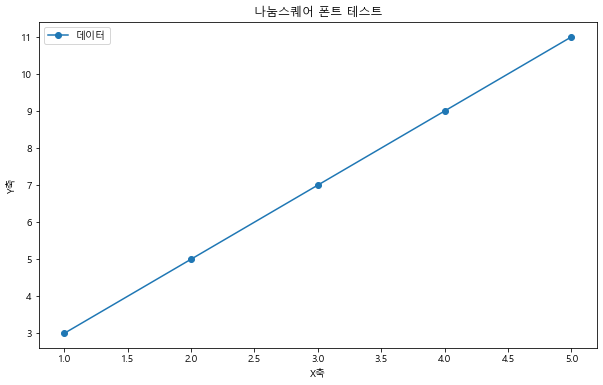

In [18]:
x = [1, 2, 3, 4, 5]
y = [3, 5, 7, 9, 11]

plt.figure(figsize=(10,6))
plt.plot(x, y, 'o-', label="데이터")
plt.title("나눔스퀘어 폰트 테스트")
plt.xlabel("X축")
plt.ylabel("Y축")
plt.legend()
plt.show()

In [19]:
raw_file = "./data/purchase_transaction_data.csv"
raw = pd.read_csv(raw_file)
raw[['Category1', 'Category2', 'Category3', 'Category4', 'Category5']] = raw['MasterCategoryFullName'].str.split('-', expand=True)
raw.loc[(raw['Category1'] == '주류') & (raw['Category2'] == ''), 'Category2'] = '주류'
raw["Sales"] = raw["Price"] * raw["SalesUnit"]
raw

,id,OrderId,PersonId,PurchaseDate,ItemDescription,SalesUnit,Price,ProductCode,MasterCategoryFullName,Agegroup,Gender,Retailer,Category1,Category2,Category3,Category4,Category5,Sales
0,2,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,대림 오양맛살270g,1,1480,8801088106118,가공식품-어육/연식품류-어육제품류-맛살,36,F,A,가공식품,어육/연식품류,어육제품류,맛살,None,1480
1,8,2021010108138430000000,168586e3815732f18f68ddef204819c7,2021-01-01,풀무원 김치뚝배기 우동 (2인),1,6180,8801114147252,가공식품-즉석/편의식품-즉석/조리식품-즉석면류,36,M,B,가공식품,즉석/편의식품,즉석/조리식품,즉석면류,None,6180
2,9,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,CJ백설소갈비양념500g,1,2580,8801007176352,가공식품-조미료-드레싱/소스-소스,36,F,A,가공식품,조미료,드레싱/소스,소스,None,2580
3,11,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,샘표맛간장조림볶음용,2,8880,8801005104067,가공식품-조미료-장류-간장,36,F,A,가공식품,조미료,장류,간장,None,17760
4,13,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,샘표맛간장국찌개1.8L,1,8900,8801005110228,가공식품-조미료-장류-간장,36,F,A,가공식품,조미료,장류,간장,None,8900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118804,390581,2021040306718280000000,eea4022e52f88e47e002bf9533aded5c,2021-04-03,빙그레 요플레 클래식,1,2800,8801104280037,가공식품-유제품-요구르트-기타요구르트,40,F,A,가공식품,유제품,요구르트,기타요구르트,None,2800
118805,390584,2021022700263890000000,eea4022e52f88e47e002bf9533aded5c,2021-02-27,풀무원 자연은맛있다,1,4980,8801114150450,가공식품-즉석/편의식품-라면류-봉지라면,40,F,A,가공식품,즉석/편의식품,라면류,봉지라면,None,4980
118806,390586,2023062500967460000000,22aca1bdf92346d1fbd589fd72622957,2023-06-25,딸기잼800g,1,5880,8809306211033,가공식품-통조림/병-농산물통조림/병-잼류/스프레드류,44,M,A,가공식품,통조림/병,농산물통조림/병,잼류/스프레드류,None,5880
118807,390588,2023062905029460000000,5957cbf9d746b210eedc703ea368a00e,2023-06-29,왓따산리오캐릭터즈13,2,500,8801062874781,가공식품-과자류-사탕류-껌류,36,F,A,가공식품,과자류,사탕류,껌류,None,1000


In [20]:
### Features 추출 
# 1. Gender : 성별 (0-Female, 1-Male)
gender = raw[['PersonId', 'Gender']].drop_duplicates()
gender['Gender'] = gender['Gender'].replace({'M': 1, 'F': 0})
# 2. AgeGroup : 연령 그룹 
agedic = {
            23 : 1, 
            24 : 2,
            28 : 3,
            32 : 4,
            36 : 5,
            40 : 6,
            44 : 7,
            48 : 8,
            52 : 9,
            56 : 10,
            60 : 11,
            64 : 12,
            65 : 13,
}
agegrp = raw[['PersonId', 'Agegroup']].drop_duplicates()
agegrp.rename(columns={'Agegroup': 'AgeGroup'}, inplace=True)
agegrp["AgeGroup"] = agegrp["AgeGroup"].map(agedic)
# 3. TotalSales : 전체 구매액
total_sales = raw.groupby('PersonId')['Sales'].sum().reset_index()
total_sales.rename(columns={'Sales': 'TotalSales'}, inplace=True)
# 4. OrderCount : 전체 구매건수
order_count = raw.groupby('PersonId')['OrderId'].nunique().reset_index()
order_count.rename(columns={'OrderId': 'OrderCount'}, inplace=True)
# 5. LiquorTotalSales : 술 전체 구매액
lq_raw = raw[raw.Category2 == "주류"]
lq_total_sales = lq_raw.groupby('PersonId')['Sales'].sum().reset_index()
lq_total_sales.rename(columns={'Sales': 'LqTotalSales'}, inplace=True)
# 6. LiquorOrderCount : 술 구매건수
lq_order_count = lq_raw.groupby('PersonId')['OrderId'].nunique().reset_index()
lq_order_count.rename(columns={'OrderId': 'LqOrderCount'}, inplace=True)
# 7. LiquorVariety : 술 구매 주종수(Category4 기준)
lq_variety = lq_raw.groupby('PersonId')['Category4'].nunique().reset_index()
lq_variety.rename(columns={'Category4': 'LqVariety'}, inplace=True)

# Merge 1~6 features 
ids_features = gender.merge(agegrp, on = 'PersonId', how = 'left') \
                     .merge(total_sales, on='PersonId', how='left') \
                     .merge(order_count, on='PersonId', how='left') \
                     .merge(lq_total_sales, on='PersonId', how='left') \
                     .merge(lq_order_count, on='PersonId', how='left') \
                     .merge(lq_variety, on='PersonId', how='left')

ids_features.fillna(0, inplace = True)

# 8. AvgSales : 건당 평균 구매액
ids_features["AvgSales"] = ids_features["TotalSales"] / ids_features["OrderCount"]
# 9. LiquorAvgSales : 건당 평균 술 구매액
ids_features["LqAvgSales"] = ids_features["LqTotalSales"] / ids_features["LqOrderCount"]
# 10. LiquorSalesRate : 술 구매액 비중
ids_features["LqSalesRate"] = ids_features["LqTotalSales"] / ids_features["TotalSales"]
# 11. LiquorOrderRate : 술 구매건 비중
ids_features["LqOrderRate"] = ids_features["LqOrderCount"] / ids_features["OrderCount"]
# 12. LiquorPeriod : 평균 술 구매 주기
tmp = lq_raw.groupby('PersonId').agg(["max", "min"])[["PurchaseDate"]].reset_index()
tmp.columns = ["PersonId", "Latest", "Oldest"]
tmp["Latest"] = pd.to_datetime(tmp["Latest"])
tmp["Oldest"] = pd.to_datetime(tmp["Oldest"])
tmp['diff'] = tmp["Latest"] - tmp["Oldest"]
tmp['diff'] = tmp['diff'].dt.days
ids_features = ids_features.merge(tmp[["PersonId", "diff"]], on = 'PersonId', how = 'left')
ids_features["LqPeriod"] = ids_features["diff"] / (ids_features["LqOrderCount"]-1)
# 13. LiquorSetOrderRate : 술 세트 구매건수 / 술 구매건수
subs = ["*", "4캔", "6캔", "2캔", "입", "케그"]
liqs = lq_raw[["ItemDescription", "Category4", "Price"]].drop_duplicates()
items = liqs["ItemDescription"].tolist()
set_list = [ii for ii in items if any(sub in ii for sub in subs)]
nset_list = [ii for ii in items if ii not in set_list]
lq_raw["isSet"] = lq_raw['ItemDescription'].apply(lambda x: 1 if x in set_list else 0)
lq_set = lq_raw[lq_raw.isSet == 1]
tmp = lq_set.groupby("PersonId")["OrderId"].nunique().reset_index()
tmp.rename(columns={'OrderId': 'LqSetOrderCount'}, inplace=True)
ids_features = ids_features.merge(tmp[["PersonId", 'LqSetOrderCount']], on = 'PersonId', how = 'left') 
ids_features["LqSetOrderRate"] = ids_features["LqSetOrderCount"] / ids_features["LqOrderCount"]

# fin.
liq_exp_ids = raw[raw.Category2 == "주류"].PersonId.unique().tolist() # 주류 구매 경험자
features = ['PersonId', 'Gender', 'AgeGroup', 
            'TotalSales', 'AvgSales', 'OrderCount',
            'LqTotalSales', 'LqAvgSales', 'LqOrderCount', 
            'LqSalesRate', 'LqOrderRate', 'LqPeriod', 'LqVariety', 'LqSetOrderRate']
ids_features = ids_features[features]
ids_features = ids_features[ids_features.PersonId.isin(liq_exp_ids)]
ids_features.fillna(0, inplace = True)

ids_features["LqTotalSales"] = ids_features["LqTotalSales"].astype(int)
ids_features["LqOrderCount"] = ids_features["LqOrderCount"].astype(int)
ids_features["LqVariety"] = ids_features["LqVariety"].astype(int)

In [21]:
ids_features.to_pickle("./data/ids_features.pkl")

# 3. t-SNE & Clustering

1) 클러스터링 사용 features
- Gender, isYoung, 
- LqAvgSales, LqSalesRate, LqOrderRate, LqPeriod, LqVariety, LqSetOrderRate

2) 주류 구매건수 2회 이상만 클러스터 분석 수행

3) isYoung - 0 or 1 : 두 그룹으로 나누어 각각 t-SNE 차원 축소 및 clustering
-> Young/Old 그룹 각각 3개 클러스터 형성(여2&남1; 결과 하단 참조)

In [22]:
import os
import pickle
from tqdm import tqdm
import itertools

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)

import seaborn as sns
import matplotlib.font_manager as fm
from matplotlib import rc
import matplotlib.pyplot as plt
plt.rc('font', family = 'Malgun Gothic')
plt.rc('axes', unicode_minus=False)
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

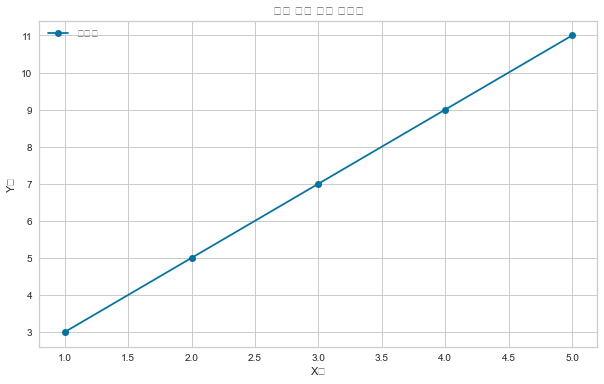

In [23]:
x = [1, 2, 3, 4, 5]
y = [3, 5, 7, 9, 11]

plt.figure(figsize=(10,6))
plt.plot(x, y, 'o-', label="데이터")
plt.title("맑은 고딕 폰트 테스트")
plt.xlabel("X축")
plt.ylabel("Y축")
plt.legend()
plt.show()

In [24]:
ids_features = pd.read_pickle("./data/ids_features.pkl")

In [25]:
# 주류 구매건수 2회 이상만 분석
ids_features = ids_features[ids_features.LqOrderCount > 1]
# AgeGroup 6 이상 : 40대
ids_features["isYoung"] = ids_features['AgeGroup'].apply(lambda x: 1 if x < 6 else 0)
features = ["PersonId", "Gender", "isYoung", 
            "LqAvgSales", "LqSalesRate", "LqOrderRate", "LqPeriod", "LqVariety", "LqSetOrderRate"]
ids_features = ids_features[features]
ids_features

,PersonId,Gender,isYoung,LqAvgSales,LqSalesRate,LqOrderRate,LqPeriod,LqVariety,LqSetOrderRate
1,168586e3815732f18f68ddef204819c7,1,1,8842.500000,0.168839,0.181818,39.333333,3,0.250000
5,0154241ac29e4922cb0218a1e098c3f3,1,1,5625.000000,0.106817,0.210526,19.666667,2,0.000000
7,8ccd35be761b542ee84618fde4593652,0,1,9335.000000,0.036046,0.079208,91.142857,6,0.375000
11,25b0578132937cd3118da233033a657d,0,0,8713.333333,0.377909,0.600000,67.500000,5,0.666667
12,66025f25f8cad43d2697ae807b30317b,0,0,7500.000000,0.008255,0.017857,135.000000,3,0.000000
...,...,...,...,...,...,...,...,...,...
2631,2d25d3f572a227429f4decc5fa4f15c3,1,0,19750.000000,0.110197,0.068966,75.000000,1,0.000000
2647,985896ef73f423e72c4f3e3dc2086043,1,0,8540.000000,0.045134,0.181818,24.000000,2,0.000000
2655,846712b0a011b6ec3bf477e89826eba5,0,1,32080.000000,0.413296,0.666667,65.000000,3,0.000000
2662,e675b45f7db8fb444590f1a7d46257aa,0,1,18870.000000,0.205377,0.500000,20.000000,3,0.500000


### Young Group

In [26]:
young_features = ids_features[ids_features.isYoung == 1]
young_features.shape

(253, 9)

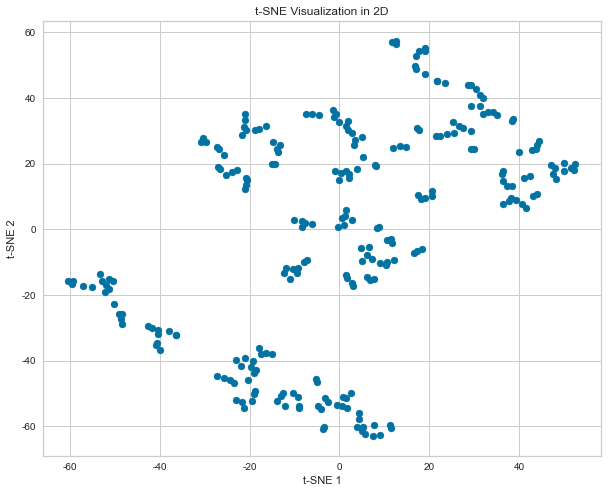

In [27]:
y_tsne_params = {
        'n_components': 2,
        'random_state': 421,
        'perplexity': 5,
        'learning_rate': 100,
        'n_iter': 1000
}
# "PersonId" 컬럼 제외
y_data_subset = young_features.drop(columns=['PersonId', "isYoung"])

# Min-Max 스케일링
y_scaler = MinMaxScaler()
y_scaled_data = y_scaler.fit_transform(y_data_subset)

# t-SNE 적용
y_tsne = TSNE(**y_tsne_params)
y_tsne_results = y_tsne.fit_transform(y_scaled_data)

# t-SNE 결과 시각화
if y_tsne_params['n_components'] == 3:
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(y_tsne_results[:, 0], y_tsne_results[:, 1], y_tsne_results[:, 2], cmap='rainbow')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.set_zlabel('t-SNE 3')
    plt.title('t-SNE Visualization in 3D')
    plt.show()
    
elif y_tsne_params['n_components'] == 2:
    plt.figure(figsize=(10,8))
    plt.scatter(y_tsne_results[:, 0], y_tsne_results[:, 1], cmap='rainbow')
    plt.title('t-SNE Visualization in 2D')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.show()

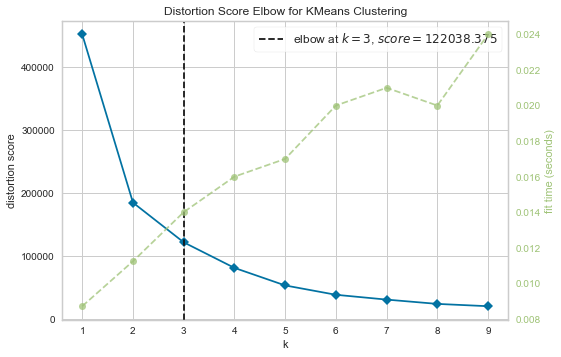

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [28]:
y_rseed = 5252
# 주성분에서 가져온 결과를 사용
y_reduced_data = y_tsne_results

# Elbow Plot
y_inertias = []
k_values = list(range(1, 11))  # 1부터 10까지 K값을 고려

for k in k_values:
    kmeans = KMeans(n_clusters = k, random_state = y_rseed)
    kmeans.fit(y_reduced_data)
    y_inertias.append(kmeans.inertia_)

y_visualizer = KElbowVisualizer(kmeans, k=(1,10), locate_elbow=True)

# t-SNE 결과를 바탕으로 최적의 클러스터 수 찾기
y_visualizer.fit(y_tsne_results)
y_visualizer.show()

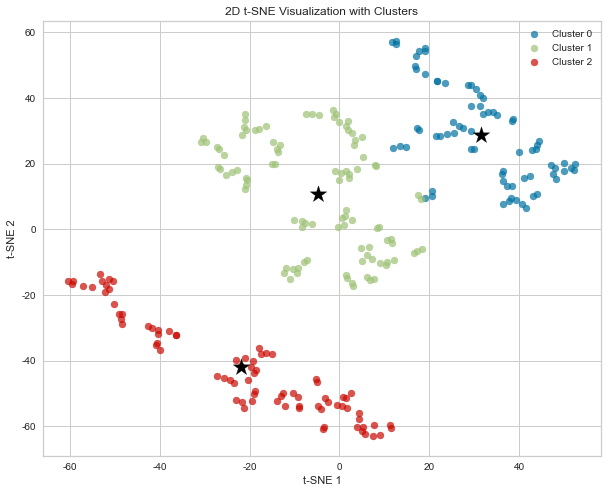

In [29]:
# K-means 클러스터링 수행
y_k_final = 3
y_kmeans = KMeans(n_clusters = y_k_final, random_state = y_rseed)
y_clusters = y_kmeans.fit_predict(y_reduced_data)

# 클러스터 1과 클러스터 2의 레이블 교환
y_clusters = np.where(y_clusters == 1, -1, y_clusters) # 임시로 클러스터 1을 -1로 변경
y_clusters = np.where(y_clusters == 2, 1, y_clusters)  # 클러스터 2를 클러스터 1로 변경
y_clusters = np.where(y_clusters == -1, 2, y_clusters) # 임시로 설정했던 -1을 클러스터 2로 변경

# 결과를 원래의 데이터 프레임에 추가
young_features['Cluster'] = y_clusters

# 조건 분기
if y_tsne_params['n_components'] == 2:
    plt.figure(figsize=(10,8))
    for cluster_num in range(y_k_final):
        subset = y_tsne_results[y_clusters == cluster_num]
        
        # 평균 지점 계산
        centroid = subset.mean(axis=0)
        
        plt.scatter(subset[:, 0], subset[:, 1], label = f'Cluster {cluster_num}', alpha=0.7)
        
        # 평균 지점에 별표 마커 추가
        plt.scatter(centroid[0], centroid[1], marker='*', s = 300, c='black')
        
    plt.title('2D t-SNE Visualization with Clusters')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend()
    plt.show()

elif y_tsne_params['n_components'] == 3:
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')
    for cluster_num in range(y_k_final):
        subset = y_tsne_results[y_clusters == cluster_num]
        
        # 평균 지점 계산
        centroid = subset.mean(axis=0)
        
        ax.scatter(subset[:, 0], subset[:, 1], subset[:, 2], label=f'Cluster {cluster_num}', alpha=0.7)
        
        # 평균 지점에 별표 마커 추가
        ax.scatter(centroid[0], centroid[1], centroid[2], marker='*', s=300, c='black')
        
    plt.title('3D t-SNE Visualization with Clusters')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.set_zlabel('t-SNE 3')
    plt.legend()
    plt.show()

else:
    print("Invalid number of t-SNE components. Please use 2 or 3.")

### Non-Young Group

In [30]:
old_features = ids_features[ids_features.isYoung == 0]
old_features.shape

(422, 9)

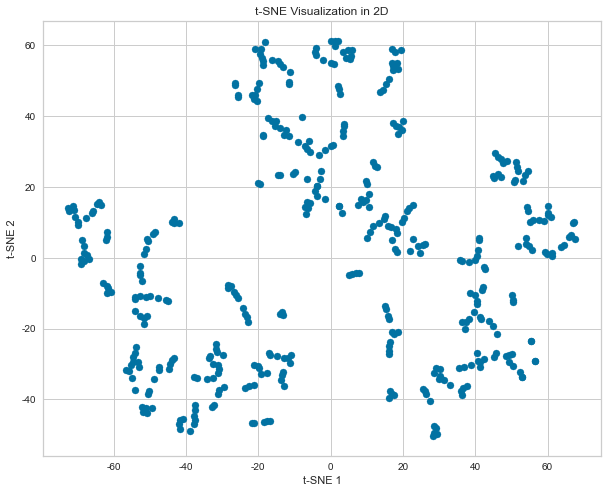

In [31]:
o_tsne_params = {
        'n_components': 2,
        'random_state': 421,
        'perplexity': 5,
        'learning_rate': 100,
        'n_iter': 1000
}

# "PersonId" 컬럼 제외
o_data_subset = old_features.drop(columns=['PersonId', "isYoung"])

# Min-Max 스케일링
o_scaler = MinMaxScaler()
o_scaled_data = o_scaler.fit_transform(o_data_subset)

# t-SNE 적용
o_tsne = TSNE(**o_tsne_params)
o_tsne_results = o_tsne.fit_transform(o_scaled_data)

# t-SNE 결과 시각화
if o_tsne_params['n_components'] == 3:
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(o_tsne_results[:, 0], o_tsne_results[:, 1], o_tsne_results[:, 2], cmap='rainbow')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.set_zlabel('t-SNE 3')
    plt.title('t-SNE Visualization in 3D')
    plt.show()
    
elif o_tsne_params['n_components'] == 2:
    plt.figure(figsize=(10,8))
    plt.scatter(o_tsne_results[:, 0], o_tsne_results[:, 1], cmap='rainbow')
    plt.title('t-SNE Visualization in 2D')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.show()

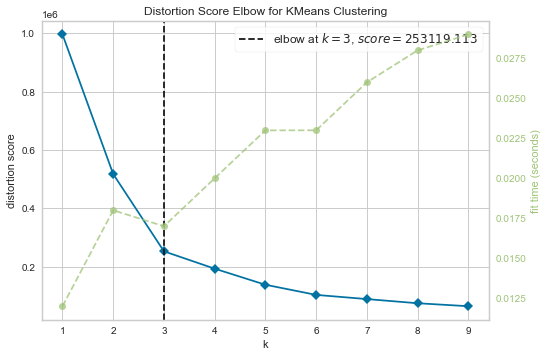

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [32]:
o_rseed = 2021
# 주성분에서 가져온 결과를 사용
o_reduced_data = o_tsne_results

# Elbow Plot
o_inertias = []
k_values = list(range(1, 11))  # 1부터 10까지 K값을 고려 (범위는 조정 가능)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state= o_rseed)
    kmeans.fit(o_reduced_data)
    o_inertias.append(kmeans.inertia_)

o_visualizer = KElbowVisualizer(kmeans, k=(1,10), locate_elbow=True)

# t-SNE 결과를 바탕으로 최적의 클러스터 수 찾기
o_visualizer.fit(o_tsne_results)
o_visualizer.show()

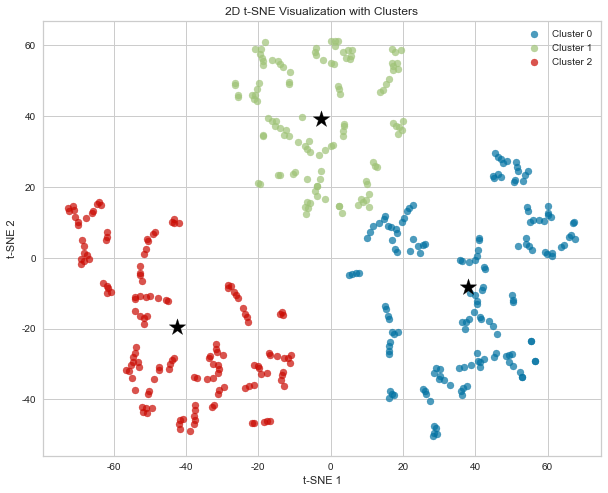

In [33]:
# K-means 클러스터링 수행
o_k_final = 3
o_kmeans = KMeans(n_clusters = o_k_final, random_state = o_rseed)
o_clusters = o_kmeans.fit_predict(o_reduced_data)

# 클러스터 1과 클러스터 2의 레이블 교환
o_clusters = np.where(o_clusters == 0, -1, o_clusters) # 임시로 클러스터 0을 -1로 변경
o_clusters = np.where(o_clusters == 2, 0, o_clusters)  # 클러스터 2를 클러스터 0로 변경
o_clusters = np.where(o_clusters == -1, 2, o_clusters) # 임시로 설정했던 -1을 클러스터 2로 변경

# 결과를 원래의 데이터 프레임에 추가 (옵션)
old_features['Cluster'] = o_clusters

# 조건 분기
if o_tsne_params['n_components'] == 2:
    plt.figure(figsize=(10,8))
    for cluster_num in range(o_k_final):
        subset = o_tsne_results[o_clusters == cluster_num]
        
        # 평균 지점 계산
        centroid = subset.mean(axis=0)
        
        plt.scatter(subset[:, 0], subset[:, 1], label=f'Cluster {cluster_num}', alpha=0.7)
        
        # 평균 지점에 별표 마커 추가
        plt.scatter(centroid[0], centroid[1], marker = '*', s = 300, c = 'black')
        
    plt.title('2D t-SNE Visualization with Clusters')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend()
    plt.show()

elif o_tsne_params['n_components'] == 3:
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')
    for cluster_num in range(o_k_final):
        subset = o_tsne_results[o_clusters == cluster_num]
        
        # 평균 지점 계산
        centroid = subset.mean(axis=0)
        
        ax.scatter(subset[:, 0], subset[:, 1], subset[:, 2], label=f'Cluster {cluster_num}', alpha=0.7)
        
        # 평균 지점에 별표 마커 추가
        ax.scatter(centroid[0], centroid[1], centroid[2], marker = '*', s = 300, c = 'black')
        
    plt.title('3D t-SNE Visualization with Clusters')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.set_zlabel('t-SNE 3')
    plt.legend()
    plt.show()

else:
    print("Invalid number of t-SNE components. Please use 2 or 3.")

In [36]:
old_features[old_features.Cluster == 1].describe()

,Gender,isYoung,LqAvgSales,LqSalesRate,LqOrderRate,LqPeriod,LqVariety,LqSetOrderRate,Cluster
count,118.0,118.0,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.0
mean,0.0,0.0,8296.709628,0.120602,0.228662,106.355942,2.610169,0.002001,1.0
std,0.0,0.0,6895.666823,0.112170,0.153671,108.868666,0.943116,0.012971,0.0
min,0.0,0.0,1380.000000,0.002729,0.013514,1.000000,1.000000,0.000000,1.0
25%,0.0,0.0,3670.000000,0.034059,0.114286,33.000000,2.000000,0.000000,1.0
50%,0.0,0.0,6738.333333,0.086707,0.195238,78.500000,2.500000,0.000000,1.0
75%,0.0,0.0,9671.500000,0.176128,0.333333,139.500000,3.000000,0.000000,1.0
max,0.0,0.0,48050.000000,0.541260,0.666667,621.000000,5.000000,0.111111,1.0


In [37]:
old_features['Cluster'] = old_features['Cluster'] + 3
clustered_features = pd.concat([young_features, old_features], axis=0).reset_index(drop=True)
clustered_features

,PersonId,Gender,isYoung,LqAvgSales,LqSalesRate,LqOrderRate,LqPeriod,LqVariety,LqSetOrderRate,Cluster
0,168586e3815732f18f68ddef204819c7,1,1,8842.5,0.168839,0.181818,39.333333,3,0.250,2
1,0154241ac29e4922cb0218a1e098c3f3,1,1,5625.0,0.106817,0.210526,19.666667,2,0.000,2
2,8ccd35be761b542ee84618fde4593652,0,1,9335.0,0.036046,0.079208,91.142857,6,0.375,0
3,37b19e0ab3c54943a1a1c58954deb757,0,1,2535.0,0.180620,0.285714,44.000000,3,0.000,1
4,5c08d360f4e23dc88f2a0f1ed2cf6a44,0,1,9305.0,0.106028,0.160000,122.333333,3,0.250,0
...,...,...,...,...,...,...,...,...,...,...
670,8f16a18bd4d53bf2cf9332e3d9bd42c6,0,0,5540.0,0.182858,0.600000,30.500000,3,0.000,3
671,8fc93616c34b9bf91213c2603d64e25a,0,0,4460.0,0.029484,0.250000,30.000000,2,0.000,4
672,2d25d3f572a227429f4decc5fa4f15c3,1,0,19750.0,0.110197,0.068966,75.000000,1,0.000,5
673,985896ef73f423e72c4f3e3dc2086043,1,0,8540.0,0.045134,0.181818,24.000000,2,0.000,5


In [38]:
clustered_features.to_pickle("./data/clustered_features.pkl")

In [39]:
raw

,id,OrderId,PersonId,PurchaseDate,ItemDescription,SalesUnit,Price,ProductCode,MasterCategoryFullName,Agegroup,Gender,Retailer,Category1,Category2,Category3,Category4,Category5,Sales
0,2,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,대림 오양맛살270g,1,1480,8801088106118,가공식품-어육/연식품류-어육제품류-맛살,36,F,A,가공식품,어육/연식품류,어육제품류,맛살,None,1480
1,8,2021010108138430000000,168586e3815732f18f68ddef204819c7,2021-01-01,풀무원 김치뚝배기 우동 (2인),1,6180,8801114147252,가공식품-즉석/편의식품-즉석/조리식품-즉석면류,36,M,B,가공식품,즉석/편의식품,즉석/조리식품,즉석면류,None,6180
2,9,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,CJ백설소갈비양념500g,1,2580,8801007176352,가공식품-조미료-드레싱/소스-소스,36,F,A,가공식품,조미료,드레싱/소스,소스,None,2580
3,11,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,샘표맛간장조림볶음용,2,8880,8801005104067,가공식품-조미료-장류-간장,36,F,A,가공식품,조미료,장류,간장,None,17760
4,13,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,샘표맛간장국찌개1.8L,1,8900,8801005110228,가공식품-조미료-장류-간장,36,F,A,가공식품,조미료,장류,간장,None,8900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118804,390581,2021040306718280000000,eea4022e52f88e47e002bf9533aded5c,2021-04-03,빙그레 요플레 클래식,1,2800,8801104280037,가공식품-유제품-요구르트-기타요구르트,40,F,A,가공식품,유제품,요구르트,기타요구르트,None,2800
118805,390584,2021022700263890000000,eea4022e52f88e47e002bf9533aded5c,2021-02-27,풀무원 자연은맛있다,1,4980,8801114150450,가공식품-즉석/편의식품-라면류-봉지라면,40,F,A,가공식품,즉석/편의식품,라면류,봉지라면,None,4980
118806,390586,2023062500967460000000,22aca1bdf92346d1fbd589fd72622957,2023-06-25,딸기잼800g,1,5880,8809306211033,가공식품-통조림/병-농산물통조림/병-잼류/스프레드류,44,M,A,가공식품,통조림/병,농산물통조림/병,잼류/스프레드류,None,5880
118807,390588,2023062905029460000000,5957cbf9d746b210eedc703ea368a00e,2023-06-29,왓따산리오캐릭터즈13,2,500,8801062874781,가공식품-과자류-사탕류-껌류,36,F,A,가공식품,과자류,사탕류,껌류,None,1000


In [40]:
clustered_features

,PersonId,Gender,isYoung,LqAvgSales,LqSalesRate,LqOrderRate,LqPeriod,LqVariety,LqSetOrderRate,Cluster
0,168586e3815732f18f68ddef204819c7,1,1,8842.5,0.168839,0.181818,39.333333,3,0.250,2
1,0154241ac29e4922cb0218a1e098c3f3,1,1,5625.0,0.106817,0.210526,19.666667,2,0.000,2
2,8ccd35be761b542ee84618fde4593652,0,1,9335.0,0.036046,0.079208,91.142857,6,0.375,0
3,37b19e0ab3c54943a1a1c58954deb757,0,1,2535.0,0.180620,0.285714,44.000000,3,0.000,1
4,5c08d360f4e23dc88f2a0f1ed2cf6a44,0,1,9305.0,0.106028,0.160000,122.333333,3,0.250,0
...,...,...,...,...,...,...,...,...,...,...
670,8f16a18bd4d53bf2cf9332e3d9bd42c6,0,0,5540.0,0.182858,0.600000,30.500000,3,0.000,3
671,8fc93616c34b9bf91213c2603d64e25a,0,0,4460.0,0.029484,0.250000,30.000000,2,0.000,4
672,2d25d3f572a227429f4decc5fa4f15c3,1,0,19750.0,0.110197,0.068966,75.000000,1,0.000,5
673,985896ef73f423e72c4f3e3dc2086043,1,0,8540.0,0.045134,0.181818,24.000000,2,0.000,5


In [41]:
clustered_raw = raw.merge(clustered_features[['PersonId', 'Cluster']], on='PersonId', how='left')
clustered_raw

,id,OrderId,PersonId,PurchaseDate,ItemDescription,SalesUnit,Price,ProductCode,MasterCategoryFullName,Agegroup,Gender,Retailer,Category1,Category2,Category3,Category4,Category5,Sales,Cluster
0,2,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,대림 오양맛살270g,1,1480,8801088106118,가공식품-어육/연식품류-어육제품류-맛살,36,F,A,가공식품,어육/연식품류,어육제품류,맛살,None,1480,NaN
1,8,2021010108138430000000,168586e3815732f18f68ddef204819c7,2021-01-01,풀무원 김치뚝배기 우동 (2인),1,6180,8801114147252,가공식품-즉석/편의식품-즉석/조리식품-즉석면류,36,M,B,가공식품,즉석/편의식품,즉석/조리식품,즉석면류,None,6180,2.0
2,9,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,CJ백설소갈비양념500g,1,2580,8801007176352,가공식품-조미료-드레싱/소스-소스,36,F,A,가공식품,조미료,드레싱/소스,소스,None,2580,NaN
3,11,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,샘표맛간장조림볶음용,2,8880,8801005104067,가공식품-조미료-장류-간장,36,F,A,가공식품,조미료,장류,간장,None,17760,NaN
4,13,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,샘표맛간장국찌개1.8L,1,8900,8801005110228,가공식품-조미료-장류-간장,36,F,A,가공식품,조미료,장류,간장,None,8900,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118804,390581,2021040306718280000000,eea4022e52f88e47e002bf9533aded5c,2021-04-03,빙그레 요플레 클래식,1,2800,8801104280037,가공식품-유제품-요구르트-기타요구르트,40,F,A,가공식품,유제품,요구르트,기타요구르트,None,2800,4.0
118805,390584,2021022700263890000000,eea4022e52f88e47e002bf9533aded5c,2021-02-27,풀무원 자연은맛있다,1,4980,8801114150450,가공식품-즉석/편의식품-라면류-봉지라면,40,F,A,가공식품,즉석/편의식품,라면류,봉지라면,None,4980,4.0
118806,390586,2023062500967460000000,22aca1bdf92346d1fbd589fd72622957,2023-06-25,딸기잼800g,1,5880,8809306211033,가공식품-통조림/병-농산물통조림/병-잼류/스프레드류,44,M,A,가공식품,통조림/병,농산물통조림/병,잼류/스프레드류,None,5880,5.0
118807,390588,2023062905029460000000,5957cbf9d746b210eedc703ea368a00e,2023-06-29,왓따산리오캐릭터즈13,2,500,8801062874781,가공식품-과자류-사탕류-껌류,36,F,A,가공식품,과자류,사탕류,껌류,None,1000,1.0


In [42]:
clustered_raw.to_excel("./data/clustered_raw.xlsx", index=False, engine='openpyxl')

# 4. Clustered Data EDA

In [49]:
import os
import pickle
from tqdm import tqdm
import itertools

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)

import seaborn as sns
import matplotlib.font_manager as fm
from matplotlib import rc
import matplotlib.pyplot as plt
plt.rc('font', family = 'Malgun Gothic')
plt.rc('axes', unicode_minus=False)

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

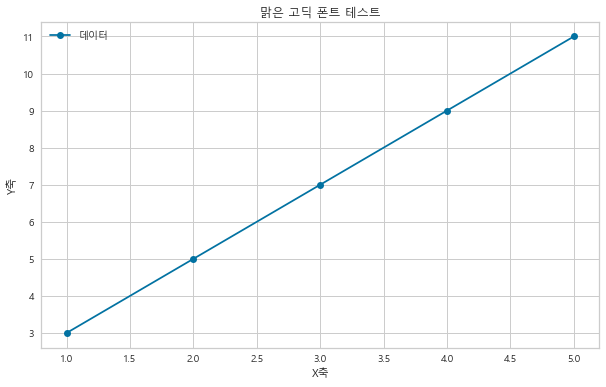

In [50]:
x = [1, 2, 3, 4, 5]
y = [3, 5, 7, 9, 11]

plt.figure(figsize=(10,6))
plt.plot(x, y, 'o-', label="데이터")
plt.title("맑은 고딕 폰트 테스트")
plt.xlabel("X축")
plt.ylabel("Y축")
plt.legend()
plt.show()

In [51]:
clustered_features = pd.read_pickle("./data/clustered_features.pkl")
clustered_features

,PersonId,Gender,isYoung,LqAvgSales,LqSalesRate,LqOrderRate,LqPeriod,LqVariety,LqSetOrderRate,Cluster
0,168586e3815732f18f68ddef204819c7,1,1,8842.5,0.168839,0.181818,39.333333,3,0.250,2
1,0154241ac29e4922cb0218a1e098c3f3,1,1,5625.0,0.106817,0.210526,19.666667,2,0.000,2
2,8ccd35be761b542ee84618fde4593652,0,1,9335.0,0.036046,0.079208,91.142857,6,0.375,0
3,37b19e0ab3c54943a1a1c58954deb757,0,1,2535.0,0.180620,0.285714,44.000000,3,0.000,1
4,5c08d360f4e23dc88f2a0f1ed2cf6a44,0,1,9305.0,0.106028,0.160000,122.333333,3,0.250,0
...,...,...,...,...,...,...,...,...,...,...
670,8f16a18bd4d53bf2cf9332e3d9bd42c6,0,0,5540.0,0.182858,0.600000,30.500000,3,0.000,3
671,8fc93616c34b9bf91213c2603d64e25a,0,0,4460.0,0.029484,0.250000,30.000000,2,0.000,4
672,2d25d3f572a227429f4decc5fa4f15c3,1,0,19750.0,0.110197,0.068966,75.000000,1,0.000,5
673,985896ef73f423e72c4f3e3dc2086043,1,0,8540.0,0.045134,0.181818,24.000000,2,0.000,5



Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        18
           1       0.96      1.00      0.98        25
           2       1.00      1.00      1.00        20
           3       1.00      0.97      0.99        39
           4       0.97      1.00      0.98        30
           5       1.00      1.00      1.00        37

    accuracy                           0.99       169
   macro avg       0.99      0.99      0.99       169
weighted avg       0.99      0.99      0.99       169


Confusion Matrix:
[[17  1  0  0  0  0]
 [ 0 25  0  0  0  0]
 [ 0  0 20  0  0  0]
 [ 0  0  0 38  1  0]
 [ 0  0  0  0 30  0]
 [ 0  0  0  0  0 37]]


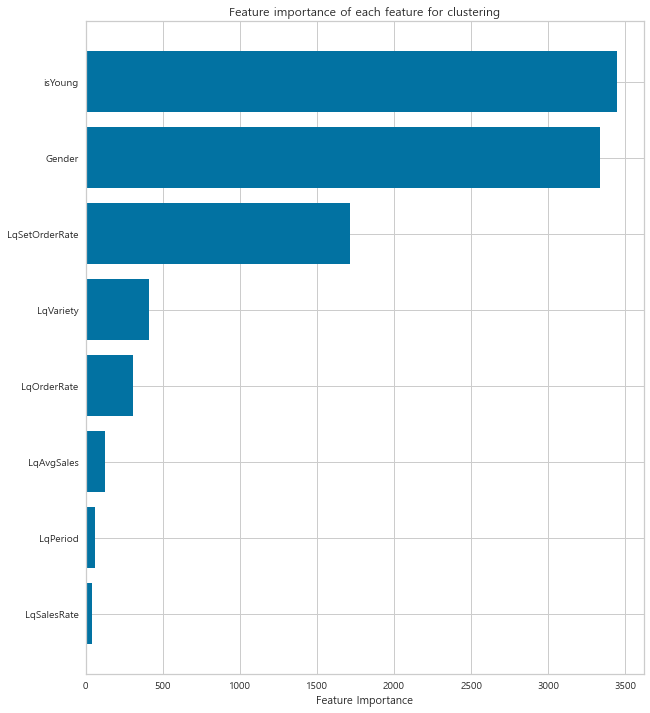

In [52]:
# 데이터 준비
X = clustered_features.drop(columns=['PersonId', 'Cluster'])
y = clustered_features['Cluster']

# 훈련/테스트 데이터 분리 (예: 80% 훈련, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 211, stratify=y)

# LightGBM 분류기 학습
d_train = lgb.Dataset(X_train, label=y_train)
params = {
    "objective": "multiclass",
    "num_class": len(y.unique()),  # 클러스터의 수
    "boosting_type": "gbdt",
    "metric": "multi_logloss",
    "verbosity": -1,
}
clf = lgb.train(params, d_train, 1000)

# 예측 및 성능 평가
y_pred = clf.predict(X_test)
y_pred_max = [np.argmax(val) for val in y_pred]

print("\nClassification Report:")
print(classification_report(y_test, y_pred_max))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_max))

# 피처 중요도 확인 및 시각화
importance = clf.feature_importance(importance_type='gain')
feature_name = X_train.columns
sorted_idx = np.argsort(importance)

plt.figure(figsize=(10, 12), facecolor = 'white')
plt.barh(range(X_train.shape[1]), importance[sorted_idx], align='center')
plt.yticks(range(X_train.shape[1]), feature_name[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature importance of each feature for clustering')
plt.show()

** 클러스터링 주요 features
1. isYoung -> Cluster 0,1,2 / 3,4,5
2. Gender -> Cluster (여) 0, 1, 3, 4 / (남) 2, 5
3. LqSetOrderRate > LqVariety > LqOrderRate > LqAvgSales > LqPeriod > LqSalesRate

In [64]:
clustered_features[clustered_features.Cluster == 5].describe()

,Gender,isYoung,LqAvgSales,LqSalesRate,LqOrderRate,LqPeriod,LqVariety,LqSetOrderRate,Cluster
count,147.0,147.0,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.0
mean,1.0,0.0,12988.057214,0.183644,0.292873,83.017524,3.435374,0.158002,5.0
std,0.0,0.0,12205.115400,0.176252,0.206598,104.581223,1.736269,0.239994,0.0
min,1.0,0.0,1660.000000,0.004894,0.033898,2.000000,1.000000,0.000000,5.0
25%,1.0,0.0,5527.750000,0.053515,0.158125,26.025538,2.000000,0.000000,5.0
50%,1.0,0.0,8593.333333,0.122323,0.250000,52.500000,3.000000,0.000000,5.0
75%,1.0,0.0,16686.666667,0.259245,0.375000,88.833333,4.000000,0.292857,5.0
max,1.0,0.0,92806.666667,0.980382,1.000000,624.000000,10.000000,1.000000,5.0


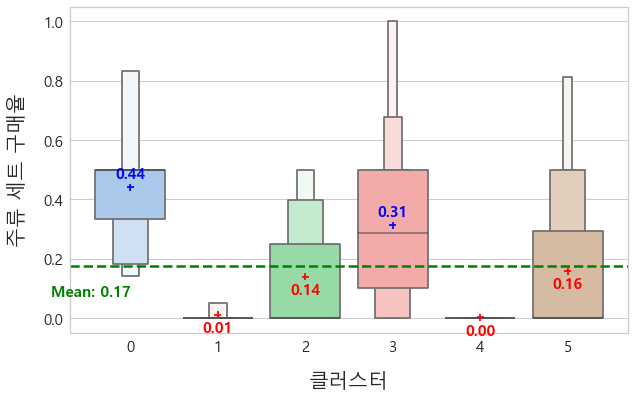

In [75]:
feature = 'LqSetOrderRate'

# 1. 박스플랏의 색상을 파스텔 색상으로 변경.
palette = sns.color_palette("pastel")

plt.figure(figsize=(10, 6), facecolor = 'white')

# sns.boxenplot의 옵션으로 이상치를 표시하지 않도록 설정
sns.boxenplot(data=clustered_features, x='Cluster', y=feature, palette=palette, showfliers=False)

# 4. 클러스터 전체의 평균을 점선으로 표시 및 수치 표시 (bold 처리 추가)
overall_mean = clustered_features[feature].mean()
plt.axhline(y=overall_mean, color='green', linestyle='--', linewidth = 2.5)
plt.text(0, overall_mean - 0.1, f"Mean: {overall_mean:.2f}", color='green', horizontalalignment='right', weight='bold', fontsize = 15)

# 3. 각 클러스터의 평균을 박스 플랏 위에 점으로 표시.
means = clustered_features.groupby('Cluster')[feature].mean()
colors = ['blue' if mean > overall_mean else 'red' for mean in means]
plt.scatter(list(range(len(means))), means, marker='+', color=colors, zorder=12, s=50)

# 각 평균치 위에 수치를 표시 (bold 처리 추가)
for i, mean in enumerate(means):
    direction = 1 if mean > overall_mean else -1
    offset = 0.03 if direction == 1 else 0.06
    fcolor = 'blue' if direction == 1 else 'red'
    plt.text(i, mean + direction * offset, f"{mean:.2f}", horizontalalignment='center', color=fcolor, fontsize=15, weight='bold')

# x축, y축 라벨의 폰트 크기 및 여백 조정
plt.xlabel('클러스터', fontsize=20, labelpad=15)
plt.ylabel("주류 세트 구매율", fontsize=20, labelpad=15)

# x축, y축 수치의 크기 조정
plt.tick_params(axis='both', labelsize=15)

plt.show()

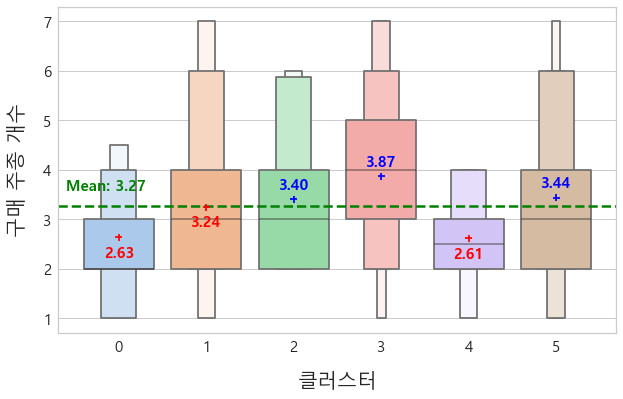

In [88]:
feature = 'LqVariety'

# 1. 박스플랏의 색상을 파스텔 색상으로 변경.
palette = sns.color_palette("pastel")

plt.figure(figsize=(10, 6), facecolor = 'white')

# sns.boxenplot의 옵션으로 이상치를 표시하지 않도록 설정
sns.boxenplot(data=clustered_features, x='Cluster', y=feature, palette=palette, showfliers=False)

# 4. 클러스터 전체의 평균을 점선으로 표시 및 수치 표시 (bold 처리 추가)
overall_mean = clustered_features[feature].mean()
plt.axhline(y=overall_mean, color='green', linestyle='--', linewidth = 2.5)
plt.text(-0.6, overall_mean +0.3, f"Mean: {overall_mean:.2f}", color='green', horizontalalignment='left', weight='bold', fontsize = 15)

# 3. 각 클러스터의 평균을 박스 플랏 위에 점으로 표시.
means = clustered_features.groupby('Cluster')[feature].mean()
colors = ['blue' if mean > overall_mean else 'red' for mean in means]
plt.scatter(list(range(len(means))), means, marker='+', color=colors, zorder=12, s=50)

# 각 평균치 위에 수치를 표시 (bold 처리 추가)
for i, mean in enumerate(means):
    direction = 1 if mean > overall_mean else -1
    offset = 0.2 if direction == 1 else 0.4
    fcolor = 'blue' if direction == 1 else 'red'
    plt.text(i, mean + direction * offset, f"{mean:.2f}", horizontalalignment='center', color=fcolor, fontsize=15, weight='bold') 

# x축, y축 라벨의 폰트 크기 및 여백 조정
plt.xlabel('클러스터', fontsize=20, labelpad=15)
plt.ylabel("구매 주종 개수", fontsize=20, labelpad=15)

# x축, y축 수치의 크기 조정
plt.tick_params(axis='both', labelsize=15)

plt.show()

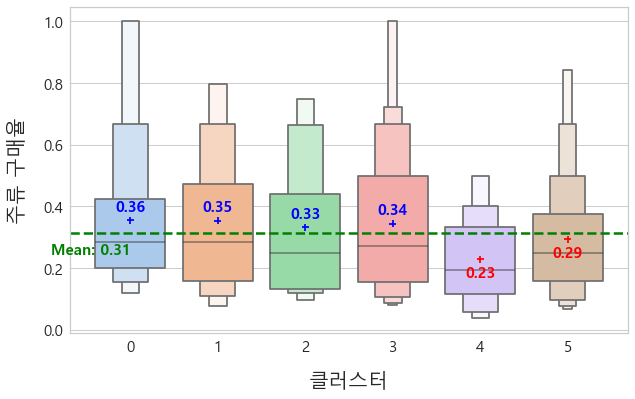

In [90]:
feature = 'LqOrderRate'

# 1. 박스플랏의 색상을 파스텔 색상으로 변경.
palette = sns.color_palette("pastel")

plt.figure(figsize=(10, 6), facecolor = 'white')

# sns.boxenplot의 옵션으로 이상치를 표시하지 않도록 설정
sns.boxenplot(data=clustered_features, x='Cluster', y=feature, palette=palette, showfliers=False)

# 4. 클러스터 전체의 평균을 점선으로 표시 및 수치 표시 (bold 처리 추가)
overall_mean = clustered_features[feature].mean()
plt.axhline(y=overall_mean, color='green', linestyle='--', linewidth = 2.5)
plt.text(0, overall_mean - 0.07, f"Mean: {overall_mean:.2f}", color='green', horizontalalignment='right', weight='bold', fontsize = 15)

# 3. 각 클러스터의 평균을 박스 플랏 위에 점으로 표시.
means = clustered_features.groupby('Cluster')[feature].mean()
colors = ['blue' if mean > overall_mean else 'red' for mean in means]
plt.scatter(list(range(len(means))), means, marker='+', color=colors, zorder=12, s=50)

# 각 평균치 위에 수치를 표시 (bold 처리 추가)
for i, mean in enumerate(means):
    direction = 1 if mean > overall_mean else -1
    offset = 0.03 if direction == 1 else 0.06
    fcolor = 'blue' if direction == 1 else 'red'
    plt.text(i, mean + direction * offset, f"{mean:.2f}", horizontalalignment='center', color=fcolor, fontsize=15, weight='bold') 

# x축, y축 라벨의 폰트 크기 및 여백 조정
plt.xlabel('클러스터', fontsize=20, labelpad=15)
plt.ylabel("주류 구매율", fontsize=20, labelpad=15)

# x축, y축 수치의 크기 조정
plt.tick_params(axis='both', labelsize=15)

plt.show()

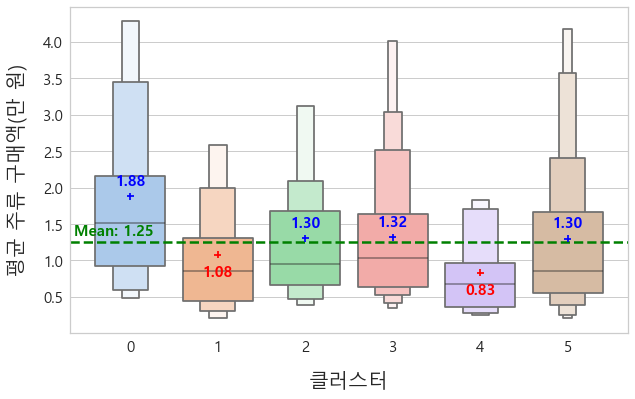

In [81]:
feature = 'LqAvgSales'

# 1. 박스플랏의 색상을 파스텔 색상으로 변경.
palette = sns.color_palette("pastel")

plt.figure(figsize=(10, 6), facecolor = 'white')

tmp = clustered_features.copy()
tmp[feature] = round(tmp[feature]/10000, 2)

# sns.boxenplot의 옵션으로 이상치를 표시하지 않도록 설정
sns.boxenplot(data=tmp, x='Cluster', y=feature, palette=palette, showfliers=False)

# 4. 클러스터 전체의 평균을 점선으로 표시 및 수치 표시 (bold 처리 추가)
overall_mean = tmp[feature].mean()
plt.axhline(y=overall_mean, color='green', linestyle='--', linewidth = 2.5)
plt.text(-0.65, overall_mean +0.09, f"Mean: {overall_mean:.2f}", color='green', horizontalalignment='left', weight='bold', fontsize = 15)

# 3. 각 클러스터의 평균을 박스 플랏 위에 점으로 표시.
means = tmp.groupby('Cluster')[feature].mean()
colors = ['blue' if mean > overall_mean else 'red' for mean in means]
plt.scatter(list(range(len(means))), means, marker='+', color=colors, zorder=12, s=50)

# 각 평균치 위에 수치를 표시 (bold 처리 추가)
for i, mean in enumerate(means):
    direction = 1 if mean > overall_mean else -1
    offset = 0.15 if direction == 1 else 0.3
    fcolor = 'blue' if direction == 1 else 'red'
    plt.text(i, mean + direction * offset, f"{mean:.2f}", horizontalalignment='center', color=fcolor, fontsize=15, weight='bold') 

# x축, y축 라벨의 폰트 크기 및 여백 조정
plt.xlabel('클러스터', fontsize=20, labelpad=15)
plt.ylabel("평균 주류 구매액(만 원)", fontsize=20, labelpad=15)

# x축, y축 수치의 크기 조정
plt.tick_params(axis='both', labelsize=15)

plt.show()

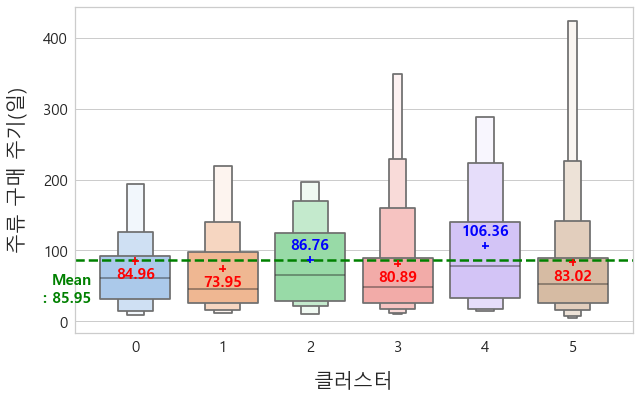

In [89]:
feature = 'LqPeriod'

# 1. 박스플랏의 색상을 파스텔 색상으로 변경.
palette = sns.color_palette("pastel")

plt.figure(figsize=(10, 6), facecolor = 'white')

# sns.boxenplot의 옵션으로 이상치를 표시하지 않도록 설정
sns.boxenplot(data=clustered_features, x='Cluster', y=feature, palette=palette, showfliers=False)

# 4. 클러스터 전체의 평균을 점선으로 표시 및 수치 표시 (bold 처리 추가)
overall_mean = clustered_features[feature].mean()
plt.axhline(y=overall_mean, color='green', linestyle='--', linewidth = 2.5)
plt.text(-0.5, overall_mean - 60, f"Mean\n: {overall_mean:.2f}", color='green', horizontalalignment='right', weight='bold', fontsize = 15)

# 3. 각 클러스터의 평균을 박스 플랏 위에 점으로 표시.
means = clustered_features.groupby('Cluster')[feature].mean()
colors = ['blue' if mean > overall_mean else 'red' for mean in means]
plt.scatter(list(range(len(means))), means, marker='+', color=colors, zorder=12, s=50)

# 각 평균치 위에 수치를 표시 (bold 처리 추가)
for i, mean in enumerate(means):
    direction = 1 if mean > overall_mean else -1
    offset = 15 if direction == 1 else 25
    fcolor = 'blue' if direction == 1 else 'red'
    plt.text(i, mean + direction * offset, f"{mean:.2f}", horizontalalignment='center', color=fcolor, fontsize=15, weight='bold') 

# x축, y축 라벨의 폰트 크기 및 여백 조정
plt.xlabel('클러스터', fontsize=20, labelpad=15)
plt.ylabel("주류 구매 주기(일)", fontsize=20, labelpad=15)

# x축, y축 수치의 크기 조정
plt.tick_params(axis='both', labelsize=15)

plt.show()

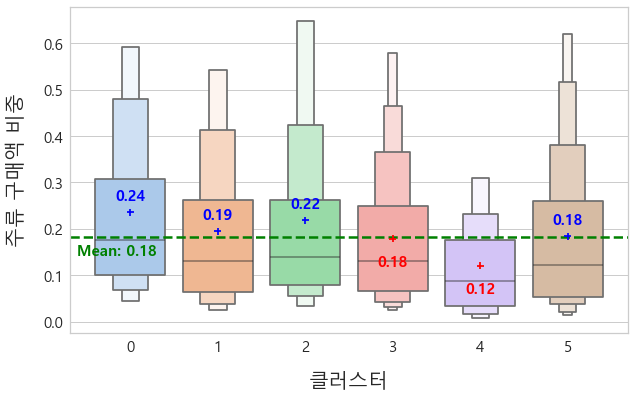

In [83]:
feature = 'LqSalesRate'

# 1. 박스플랏의 색상을 파스텔 색상으로 변경.
palette = sns.color_palette("pastel")

plt.figure(figsize=(10, 6), facecolor = 'white')

# sns.boxenplot의 옵션으로 이상치를 표시하지 않도록 설정
sns.boxenplot(data=clustered_features, x='Cluster', y=feature, palette=palette, showfliers=False)

# 4. 클러스터 전체의 평균을 점선으로 표시 및 수치 표시 (bold 처리 추가)
overall_mean = clustered_features[feature].mean()
plt.axhline(y=overall_mean, color='green', linestyle='--', linewidth = 2.5)
plt.text(-0.15, overall_mean - 0.04, f"Mean: {overall_mean:.2f}", color='green', horizontalalignment='center', weight='bold', fontsize = 15)

# 3. 각 클러스터의 평균을 박스 플랏 위에 점으로 표시.
means = clustered_features.groupby('Cluster')[feature].mean()
colors = ['blue' if mean > overall_mean else 'red' for mean in means]
plt.scatter(list(range(len(means))), means, marker='+', color=colors, zorder=12, s=50)

# 각 평균치 위에 수치를 표시 (bold 처리 추가)
for i, mean in enumerate(means):
    direction = 1 if mean > overall_mean else -1
    offset = 0.025 if direction == 1 else 0.06
    fcolor = 'blue' if direction == 1 else 'red'
    plt.text(i, mean + direction * offset, f"{mean:.2f}", horizontalalignment='center', color=fcolor, fontsize=15, weight='bold') 

# x축, y축 라벨의 폰트 크기 및 여백 조정
plt.xlabel('클러스터', fontsize=20, labelpad=15)
plt.ylabel("주류 구매액 비중", fontsize=20, labelpad=15)

# x축, y축 수치의 크기 조정
plt.tick_params(axis='both', labelsize=15)

plt.show()

#### 클러스터 X 요일 주류 소비액

In [84]:
clustered_raw = pd.read_excel("./data/clustered_raw.xlsx")
clustered_raw

,id,OrderId,PersonId,PurchaseDate,ItemDescription,SalesUnit,Price,ProductCode,MasterCategoryFullName,Agegroup,Gender,Retailer,Category1,Category2,Category3,Category4,Category5,Sales,Cluster
0,2,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,대림 오양맛살270g,1,1480,8801088106118,가공식품-어육/연식품류-어육제품류-맛살,36,F,A,가공식품,어육/연식품류,어육제품류,맛살,NaN,1480,NaN
1,8,2021010108138430000000,168586e3815732f18f68ddef204819c7,2021-01-01,풀무원 김치뚝배기 우동 (2인),1,6180,8801114147252,가공식품-즉석/편의식품-즉석/조리식품-즉석면류,36,M,B,가공식품,즉석/편의식품,즉석/조리식품,즉석면류,NaN,6180,2.0
2,9,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,CJ백설소갈비양념500g,1,2580,8801007176352,가공식품-조미료-드레싱/소스-소스,36,F,A,가공식품,조미료,드레싱/소스,소스,NaN,2580,NaN
3,11,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,샘표맛간장조림볶음용,2,8880,8801005104067,가공식품-조미료-장류-간장,36,F,A,가공식품,조미료,장류,간장,NaN,17760,NaN
4,13,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,샘표맛간장국찌개1.8L,1,8900,8801005110228,가공식품-조미료-장류-간장,36,F,A,가공식품,조미료,장류,간장,NaN,8900,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118804,390581,2021040306718280000000,eea4022e52f88e47e002bf9533aded5c,2021-04-03,빙그레 요플레 클래식,1,2800,8801104280037,가공식품-유제품-요구르트-기타요구르트,40,F,A,가공식품,유제품,요구르트,기타요구르트,NaN,2800,4.0
118805,390584,2021022700263890000000,eea4022e52f88e47e002bf9533aded5c,2021-02-27,풀무원 자연은맛있다,1,4980,8801114150450,가공식품-즉석/편의식품-라면류-봉지라면,40,F,A,가공식품,즉석/편의식품,라면류,봉지라면,NaN,4980,4.0
118806,390586,2023062500967460000000,22aca1bdf92346d1fbd589fd72622957,2023-06-25,딸기잼800g,1,5880,8809306211033,가공식품-통조림/병-농산물통조림/병-잼류/스프레드류,44,M,A,가공식품,통조림/병,농산물통조림/병,잼류/스프레드류,NaN,5880,5.0
118807,390588,2023062905029460000000,5957cbf9d746b210eedc703ea368a00e,2023-06-29,왓따산리오캐릭터즈13,2,500,8801062874781,가공식품-과자류-사탕류-껌류,36,F,A,가공식품,과자류,사탕류,껌류,NaN,1000,1.0


In [85]:
clustered_raw["PurchaseDate"] = pd.to_datetime(clustered_raw["PurchaseDate"])
days_in_korean = ["월", "화", "수", "목", "금", "토", "일"]
clustered_raw['요일'] = clustered_raw['PurchaseDate'].dt.dayofweek.apply(lambda x: days_in_korean[x])
clustered_raw

,id,OrderId,PersonId,PurchaseDate,ItemDescription,SalesUnit,Price,ProductCode,MasterCategoryFullName,Agegroup,Gender,Retailer,Category1,Category2,Category3,Category4,Category5,Sales,Cluster,요일
0,2,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,대림 오양맛살270g,1,1480,8801088106118,가공식품-어육/연식품류-어육제품류-맛살,36,F,A,가공식품,어육/연식품류,어육제품류,맛살,NaN,1480,NaN,목
1,8,2021010108138430000000,168586e3815732f18f68ddef204819c7,2021-01-01,풀무원 김치뚝배기 우동 (2인),1,6180,8801114147252,가공식품-즉석/편의식품-즉석/조리식품-즉석면류,36,M,B,가공식품,즉석/편의식품,즉석/조리식품,즉석면류,NaN,6180,2.0,금
2,9,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,CJ백설소갈비양념500g,1,2580,8801007176352,가공식품-조미료-드레싱/소스-소스,36,F,A,가공식품,조미료,드레싱/소스,소스,NaN,2580,NaN,목
3,11,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,샘표맛간장조림볶음용,2,8880,8801005104067,가공식품-조미료-장류-간장,36,F,A,가공식품,조미료,장류,간장,NaN,17760,NaN,목
4,13,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,샘표맛간장국찌개1.8L,1,8900,8801005110228,가공식품-조미료-장류-간장,36,F,A,가공식품,조미료,장류,간장,NaN,8900,NaN,목
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118804,390581,2021040306718280000000,eea4022e52f88e47e002bf9533aded5c,2021-04-03,빙그레 요플레 클래식,1,2800,8801104280037,가공식품-유제품-요구르트-기타요구르트,40,F,A,가공식품,유제품,요구르트,기타요구르트,NaN,2800,4.0,토
118805,390584,2021022700263890000000,eea4022e52f88e47e002bf9533aded5c,2021-02-27,풀무원 자연은맛있다,1,4980,8801114150450,가공식품-즉석/편의식품-라면류-봉지라면,40,F,A,가공식품,즉석/편의식품,라면류,봉지라면,NaN,4980,4.0,토
118806,390586,2023062500967460000000,22aca1bdf92346d1fbd589fd72622957,2023-06-25,딸기잼800g,1,5880,8809306211033,가공식품-통조림/병-농산물통조림/병-잼류/스프레드류,44,M,A,가공식품,통조림/병,농산물통조림/병,잼류/스프레드류,NaN,5880,5.0,일
118807,390588,2023062905029460000000,5957cbf9d746b210eedc703ea368a00e,2023-06-29,왓따산리오캐릭터즈13,2,500,8801062874781,가공식품-과자류-사탕류-껌류,36,F,A,가공식품,과자류,사탕류,껌류,NaN,1000,1.0,목


In [86]:
liq_raw = clustered_raw[clustered_raw.Category2 == "주류"]
clustered_liq = {}
for ii in range(6) :
    clustered_liq[ii] = liq_raw[liq_raw.Cluster == ii]

In [87]:
print("클러스터 X 요일 - 주류 평균 구매액")
for ii in range(6) :
    grouped_liq = clustered_liq[ii].groupby('OrderId').agg({
                                                            'Sales': 'sum',
                                                            '요일': 'first'
    }).reset_index()
    sales_byday = round(grouped_liq.groupby('요일')["Sales"].mean(), 2)
    sales_byday = sales_byday.sort_values(ascending = False)
    print("============================")
    print(f"Cluster{ii}")
    print(sales_byday)
    print()

클러스터 X 요일 - 주류 평균 구매액
Cluster0
요일
수    25533.50
금    25374.33
화    20023.75
월    19401.60
토    17469.80
일    12985.61
목     9861.03
Name: Sales, dtype: float64

Cluster1
요일
금    15609.60
수    11710.00
월    11662.14
토    11156.32
일    11107.20
목     8344.90
화     7090.87
Name: Sales, dtype: float64

Cluster2
요일
수    20397.35
금    15444.08
토    12842.86
목    12385.91
월    11837.00
일    11636.73
화    11495.33
Name: Sales, dtype: float64

Cluster3
요일
목    15491.60
일    14976.32
월    13019.90
토    12648.81
화    12447.98
금    11392.67
수     9684.33
Name: Sales, dtype: float64

Cluster4
요일
토    10559.22
일     8508.87
월     7291.53
목     6870.24
수     6574.69
금     6371.78
화     5190.71
Name: Sales, dtype: float64

Cluster5
요일
목    14770.59
수    13705.86
금    13402.45
일    12840.98
토    12281.41
화    10954.44
월     9467.19
Name: Sales, dtype: float64



#### 클러스터별 선호 주종

클러스터별 전체 주류 구매액 中 주종별 비중을 계산하여, 파이차트 시각화<br>
-> 가장 비중 높은 주종 확인 가능

In [91]:
tmp_raw = pd.read_excel("./data/final_transaction_final_org.xlsx")
tmp_raw = tmp_raw[~tmp_raw.LiquorCategory.isnull()]

In [92]:
tmp_raw = tmp_raw[["ProductCode", "LiquorCategory"]].drop_duplicates()
tmp_raw

,ProductCode,LiquorCategory
3,8594404008042,맥주
16,8801021214375,수입맥주
20,8801048101115,소주
35,8801048101023,소주
76,8809556110001,맥주
...,...,...
66183,8801119834201,맥주
66251,7808725404607,와인
66538,8801021105918,맥주
66545,8802340151761,와인


In [93]:
clustered_raw = clustered_raw.merge(tmp_raw[["ProductCode", "LiquorCategory"]], on = 'ProductCode', how = 'left')
clustered_raw

,id,OrderId,PersonId,PurchaseDate,ItemDescription,SalesUnit,Price,ProductCode,MasterCategoryFullName,Agegroup,...,Retailer,Category1,Category2,Category3,Category4,Category5,Sales,Cluster,요일,LiquorCategory
0,2,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,대림 오양맛살270g,1,1480,8801088106118,가공식품-어육/연식품류-어육제품류-맛살,36,...,A,가공식품,어육/연식품류,어육제품류,맛살,NaN,1480,NaN,목,NaN
1,8,2021010108138430000000,168586e3815732f18f68ddef204819c7,2021-01-01,풀무원 김치뚝배기 우동 (2인),1,6180,8801114147252,가공식품-즉석/편의식품-즉석/조리식품-즉석면류,36,...,B,가공식품,즉석/편의식품,즉석/조리식품,즉석면류,NaN,6180,2.0,금,NaN
2,9,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,CJ백설소갈비양념500g,1,2580,8801007176352,가공식품-조미료-드레싱/소스-소스,36,...,A,가공식품,조미료,드레싱/소스,소스,NaN,2580,NaN,목,NaN
3,11,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,샘표맛간장조림볶음용,2,8880,8801005104067,가공식품-조미료-장류-간장,36,...,A,가공식품,조미료,장류,간장,NaN,17760,NaN,목,NaN
4,13,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,샘표맛간장국찌개1.8L,1,8900,8801005110228,가공식품-조미료-장류-간장,36,...,A,가공식품,조미료,장류,간장,NaN,8900,NaN,목,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118804,390581,2021040306718280000000,eea4022e52f88e47e002bf9533aded5c,2021-04-03,빙그레 요플레 클래식,1,2800,8801104280037,가공식품-유제품-요구르트-기타요구르트,40,...,A,가공식품,유제품,요구르트,기타요구르트,NaN,2800,4.0,토,NaN
118805,390584,2021022700263890000000,eea4022e52f88e47e002bf9533aded5c,2021-02-27,풀무원 자연은맛있다,1,4980,8801114150450,가공식품-즉석/편의식품-라면류-봉지라면,40,...,A,가공식품,즉석/편의식품,라면류,봉지라면,NaN,4980,4.0,토,NaN
118806,390586,2023062500967460000000,22aca1bdf92346d1fbd589fd72622957,2023-06-25,딸기잼800g,1,5880,8809306211033,가공식품-통조림/병-농산물통조림/병-잼류/스프레드류,44,...,A,가공식품,통조림/병,농산물통조림/병,잼류/스프레드류,NaN,5880,5.0,일,NaN
118807,390588,2023062905029460000000,5957cbf9d746b210eedc703ea368a00e,2023-06-29,왓따산리오캐릭터즈13,2,500,8801062874781,가공식품-과자류-사탕류-껌류,36,...,A,가공식품,과자류,사탕류,껌류,NaN,1000,1.0,목,NaN


In [94]:
new_LC = {
            '한강 맥주' : "맥주",
            '앱솔루트 라임375ml' : "보드카", 
            '화요 25도 200ml(25%)' : "소주", 
            '려 증류소주 75ml 25%' : "소주",
            '려 증류소주 75ml 40%' : "소주", 
            '좋은데이' : "소주", 
            '아랄디카 브라퀘토 돌체' : "와인", 
            '조니워커 그린라벨 70' : "위스키",
            'L 리제르바 멜롯' : "와인", 
            '알타비스타 클래식 말' : "와인", 
            '필굿(캔/500ml)' : "맥주", 
            '빌라M 골드' : "와인",
            '단즈카 보드카(750)' : "보드카", 
            '어반레빗 바이젠500ml' : "수입맥주", 
            '△장수홍삼막걸리750ml' : "탁주", 
            '발렌타인 17년 (500)' : "와인",
            '화이트소주' : "소주", 
            '솔송주375ml' : "민속주/전통주", 
            'L 라거 (캔)' : "수입맥주", 
            'L 다크 (캔)' : "수입맥주",
            '이슬톡톡 캔디바' : "소주혼성주",
            '코노수르 비씨클레타' : "와인", 
            '몽키숄더 700ml' : "위스키", 
            '필굿' : "맥주", 
            '탱커레이 No10 700ml' : "진/럼/데킬라/아쿠아비트",
            '테라 전용잔 기획(400' : "맥주"
}

clustered_raw.loc[clustered_raw['ItemDescription'].isin(new_LC.keys()), 'LiquorCategory'] = clustered_raw['ItemDescription'].map(new_LC)

In [277]:
%%time
clustered_raw.to_excel("./data/clustered_raw(주종+Cluster).xlsx", index=False, engine='openpyxl')
clustered_raw

CPU times: total: 57.2 s
Wall time: 57.4 s


,id,OrderId,PersonId,PurchaseDate,ItemDescription,SalesUnit,Price,ProductCode,MasterCategoryFullName,Agegroup,...,Retailer,Category1,Category2,Category3,Category4,Category5,Sales,Cluster,요일,LiquorCategory
0,2,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,대림 오양맛살270g,1,1480,8801088106118,가공식품-어육/연식품류-어육제품류-맛살,36,...,A,가공식품,어육/연식품류,어육제품류,맛살,NaN,1480,NaN,목,NaN
1,8,2021010108138430000000,168586e3815732f18f68ddef204819c7,2021-01-01,풀무원 김치뚝배기 우동 (2인),1,6180,8801114147252,가공식품-즉석/편의식품-즉석/조리식품-즉석면류,36,...,B,가공식품,즉석/편의식품,즉석/조리식품,즉석면류,NaN,6180,2.0,금,NaN
2,9,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,CJ백설소갈비양념500g,1,2580,8801007176352,가공식품-조미료-드레싱/소스-소스,36,...,A,가공식품,조미료,드레싱/소스,소스,NaN,2580,NaN,목,NaN
3,11,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,샘표맛간장조림볶음용,2,8880,8801005104067,가공식품-조미료-장류-간장,36,...,A,가공식품,조미료,장류,간장,NaN,17760,NaN,목,NaN
4,13,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,샘표맛간장국찌개1.8L,1,8900,8801005110228,가공식품-조미료-장류-간장,36,...,A,가공식품,조미료,장류,간장,NaN,8900,NaN,목,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118804,390581,2021040306718280000000,eea4022e52f88e47e002bf9533aded5c,2021-04-03,빙그레 요플레 클래식,1,2800,8801104280037,가공식품-유제품-요구르트-기타요구르트,40,...,A,가공식품,유제품,요구르트,기타요구르트,NaN,2800,4.0,토,NaN
118805,390584,2021022700263890000000,eea4022e52f88e47e002bf9533aded5c,2021-02-27,풀무원 자연은맛있다,1,4980,8801114150450,가공식품-즉석/편의식품-라면류-봉지라면,40,...,A,가공식품,즉석/편의식품,라면류,봉지라면,NaN,4980,4.0,토,NaN
118806,390586,2023062500967460000000,22aca1bdf92346d1fbd589fd72622957,2023-06-25,딸기잼800g,1,5880,8809306211033,가공식품-통조림/병-농산물통조림/병-잼류/스프레드류,44,...,A,가공식품,통조림/병,농산물통조림/병,잼류/스프레드류,NaN,5880,5.0,일,NaN
118807,390588,2023062905029460000000,5957cbf9d746b210eedc703ea368a00e,2023-06-29,왓따산리오캐릭터즈13,2,500,8801062874781,가공식품-과자류-사탕류-껌류,36,...,A,가공식품,과자류,사탕류,껌류,NaN,1000,1.0,목,NaN


In [281]:
clustered_raw[~clustered_raw.Cluster.isnull()]

,id,OrderId,PersonId,PurchaseDate,ItemDescription,SalesUnit,Price,ProductCode,MasterCategoryFullName,Agegroup,...,Retailer,Category1,Category2,Category3,Category4,Category5,Sales,Cluster,요일,LiquorCategory
1,8,2021010108138430000000,168586e3815732f18f68ddef204819c7,2021-01-01,풀무원 김치뚝배기 우동 (2인),1,6180,8801114147252,가공식품-즉석/편의식품-즉석/조리식품-즉석면류,36,...,B,가공식품,즉석/편의식품,즉석/조리식품,즉석면류,NaN,6180,2.0,금,NaN
23,51,2021010100727260000000,0154241ac29e4922cb0218a1e098c3f3,2021-01-01,풀무원 얼큰순두부찌개(600G),1,3900,8801114143377,가공식품-즉석/편의식품-즉석/조리식품-즉석국/찌개류,32,...,B,가공식품,즉석/편의식품,즉석/조리식품,즉석국/찌개류,NaN,3900,2.0,금,NaN
25,55,2021010100727260000000,0154241ac29e4922cb0218a1e098c3f3,2021-01-01,풀무원 바지락순두부찌개(602G),1,3900,8801114143391,가공식품-즉석/편의식품-즉석/조리식품-즉석국/찌개류,32,...,B,가공식품,즉석/편의식품,즉석/조리식품,즉석국/찌개류,NaN,3900,2.0,금,NaN
26,57,2021010100727260000000,0154241ac29e4922cb0218a1e098c3f3,2021-01-01,백설 돼지불고기양념 500g,1,3400,8801007176376,가공식품-조미료-드레싱/소스-소스,32,...,B,가공식품,조미료,드레싱/소스,소스,NaN,3400,2.0,금,NaN
29,62,2021010100727260000000,0154241ac29e4922cb0218a1e098c3f3,2021-01-01,어깨동무 알찬콩 두부(300g),1,1000,8802015112059,가공식품-어육/연식품류-연식품-두부,32,...,B,가공식품,어육/연식품류,연식품,두부,NaN,1000,2.0,금,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118804,390581,2021040306718280000000,eea4022e52f88e47e002bf9533aded5c,2021-04-03,빙그레 요플레 클래식,1,2800,8801104280037,가공식품-유제품-요구르트-기타요구르트,40,...,A,가공식품,유제품,요구르트,기타요구르트,NaN,2800,4.0,토,NaN
118805,390584,2021022700263890000000,eea4022e52f88e47e002bf9533aded5c,2021-02-27,풀무원 자연은맛있다,1,4980,8801114150450,가공식품-즉석/편의식품-라면류-봉지라면,40,...,A,가공식품,즉석/편의식품,라면류,봉지라면,NaN,4980,4.0,토,NaN
118806,390586,2023062500967460000000,22aca1bdf92346d1fbd589fd72622957,2023-06-25,딸기잼800g,1,5880,8809306211033,가공식품-통조림/병-농산물통조림/병-잼류/스프레드류,44,...,A,가공식품,통조림/병,농산물통조림/병,잼류/스프레드류,NaN,5880,5.0,일,NaN
118807,390588,2023062905029460000000,5957cbf9d746b210eedc703ea368a00e,2023-06-29,왓따산리오캐릭터즈13,2,500,8801062874781,가공식품-과자류-사탕류-껌류,36,...,A,가공식품,과자류,사탕류,껌류,NaN,1000,1.0,목,NaN


In [102]:
liquor_df = clustered_raw[~clustered_raw.LiquorCategory.isnull()]
liquor_order = list(np.unique(liquor_df["OrderId"]))
liquor_purchased = clustered_raw[clustered_raw.OrderId.isin(liquor_order)]
liquor_purchased

,id,OrderId,PersonId,PurchaseDate,ItemDescription,SalesUnit,Price,ProductCode,MasterCategoryFullName,Agegroup,...,Retailer,Category1,Category2,Category3,Category4,Category5,Sales,Cluster,요일,LiquorCategory
24,52,2021020606158990000000,60330d2a5e56d8a3ec03fe8020f34467,2021-02-06,대림 랍스터킹 256g,1,4980,8801066056541,가공식품-어육/연식품류-어육제품류-어묵,36,...,B,가공식품,어육/연식품류,어육제품류,어묵,NaN,4980,NaN,토,NaN
27,58,2021020606158990000000,60330d2a5e56d8a3ec03fe8020f34467,2021-02-06,농심 포스틱 84g,1,1200,8801043036436,가공식품-과자류-비스킷-스낵,36,...,B,가공식품,과자류,비스킷,스낵,NaN,1200,NaN,토,NaN
28,59,2021020606158990000000,60330d2a5e56d8a3ec03fe8020f34467,2021-02-06,농심 안성탕면 5개입,1,2750,8801043014786,가공식품-즉석/편의식품-라면류-봉지라면,36,...,B,가공식품,즉석/편의식품,라면류,봉지라면,NaN,2750,NaN,토,NaN
30,63,2021020606158990000000,60330d2a5e56d8a3ec03fe8020f34467,2021-02-06,광동제약 힘찬하루헛개차 1.5L,1,1080,8806002009391,가공식품-차류-차음료-기타차음료,36,...,B,가공식품,차류,차음료,기타차음료,NaN,1080,NaN,토,NaN
31,70,2021020606158990000000,60330d2a5e56d8a3ec03fe8020f34467,2021-02-06,코카콜라 미닛메이드 제주감귤 1.5L,1,2580,8801094626402,가공식품-음료류-주스-혼합주스음료,36,...,B,가공식품,음료류,주스,혼합주스음료,NaN,2580,NaN,토,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118796,390562,2021041100103170000000,eea4022e52f88e47e002bf9533aded5c,2021-04-11,딸기어린이음료 200ml,1,680,8801382146674,가공식품-영유아식품-영유아용간식-영유아용음료,40,...,A,가공식품,영유아식품,영유아용간식,영유아용음료,NaN,680,4.0,일,NaN
118797,390563,2021041100103170000000,eea4022e52f88e47e002bf9533aded5c,2021-04-11,사과어린이음료200ml,1,680,8801382146681,가공식품-영유아식품-영유아용간식-영유아용음료,40,...,A,가공식품,영유아식품,영유아용간식,영유아용음료,NaN,680,4.0,일,NaN
118798,390564,2021041100103170000000,eea4022e52f88e47e002bf9533aded5c,2021-04-11,롯데빈츠204g,1,2580,8801062634453,가공식품-과자류-비스킷-쿠키류,40,...,A,가공식품,과자류,비스킷,쿠키류,NaN,2580,4.0,일,NaN
118799,390566,2021041100103170000000,eea4022e52f88e47e002bf9533aded5c,2021-04-11,삼양 짜짜로니 140g*4,1,2980,8801073142473,가공식품-즉석/편의식품-라면류-봉지라면,40,...,A,가공식품,즉석/편의식품,라면류,봉지라면,NaN,2980,4.0,일,NaN


In [110]:
liq_purchased_dic = {}
for c in range(6) :
    liq_purchased_dic[f"C{c}"] = liquor_purchased[liquor_purchased.Cluster == c]
    
liq_cats = ['고량주', '과실주', '과실주스파클링', '과실주혼성주', '기타주류', '기타주류혼성주', '기타증류주',
       '리큐르', '맥주', '맥주라이트', '민속주/전통주', '민속주/전통주차례주', '민속주/전통주혼성주', '보드카',
       '보드카혼성주', '샴페인', '소주', '소주담금주', '소주혼성주', '수입맥주', '수입맥주논알콜',
       '수입맥주혼성주', '약주', '약주차례주', '약주혼성주', '와인', '위스키', '진/럼/데킬라/아쿠아비트',
       '청주', '탁주', '탁주유산균', '탁주혼성주']

cluster_dic = {}
for c in range(6) :
    tmp = liq_purchased_dic[f"C{c}"]
    tmp_dic = {}
    for target in liq_cats :
        sum_value = tmp[tmp.LiquorCategory == target].Sales.sum()
        tmp_dic[target] = sum_value
    tmp_df = pd.DataFrame(list(tmp_dic.items()), columns = ["Type", "Sales"])
    tmp_df.sort_values(by = "Sales", ascending = False, inplace = True)
    cluster_dic[f"C{c}"] = tmp_df

In [120]:
cluster_dic["C2"]

,Type,Sales
8,맥주,1019320
16,소주,931050
26,위스키,853480
19,수입맥주,693740
25,와인,419250
13,보드카,382300
1,과실주,237560
10,민속주/전통주,108930
4,기타주류,108730
7,리큐르,96560


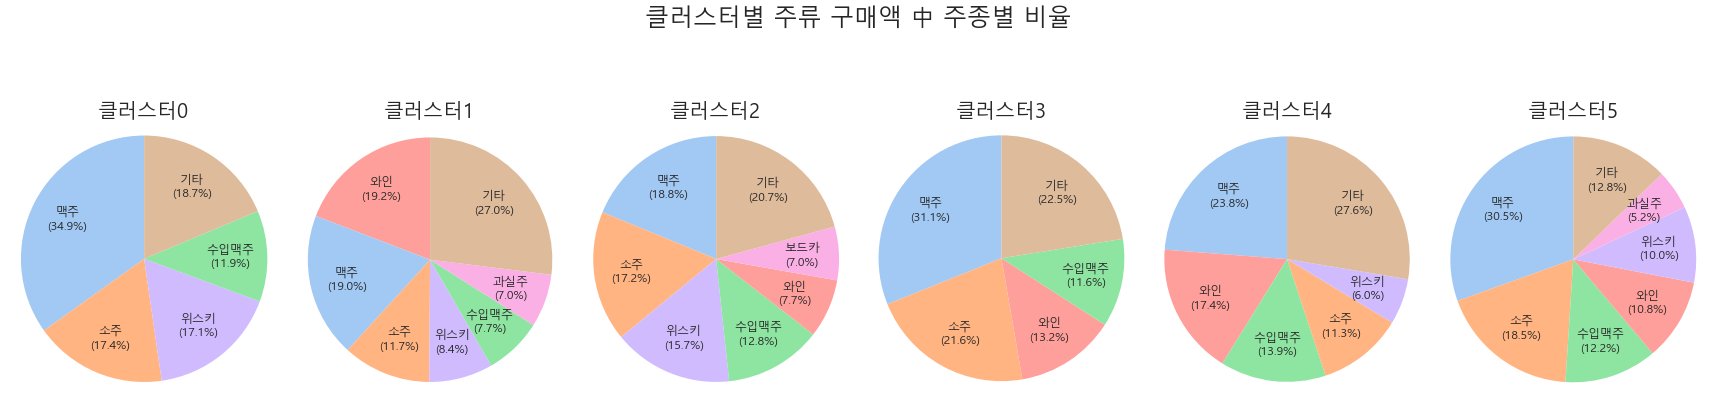

In [124]:
all_types = ["맥주", "소주", "수입맥주", "와인", "위스키", "과실주", "보드카", "기타"]
palette = sns.color_palette("pastel", len(all_types))
color_dict = {typ: palette[i] for i, typ in enumerate(all_types)}
color_dict["과실주"] =  (0.9803921568627451, 0.6901960784313725, 0.8941176470588236)
color_dict["기타"] = (0.8705882352941177, 0.7333333333333333, 0.6078431372549019)

fig, axes = plt.subplots(1, 6, figsize=(24, 5), facecolor="white")

for idx, ax in enumerate(axes):
    d = cluster_dic[f"C{idx}"]
    total_sales = d['Sales'].sum()
    threshold = 0.05 * total_sales

    small_sales = d[d['Sales'] < threshold]['Sales'].sum()
    filtered_d = d[d['Sales'] >= threshold]

    etc_value = small_sales + (filtered_d[filtered_d['Type'] == '기타']['Sales'].sum() if '기타' in filtered_d['Type'].values else 0)
    
    sales_dict = {}
    for typ in all_types:
        if typ == '기타':
            sales_dict[typ] = etc_value
        elif typ in filtered_d['Type'].values:
            sales_dict[typ] = filtered_d[filtered_d['Type'] == typ]['Sales'].values[0]
        else:
            sales_dict[typ] = 0
    
    # "기타"를 제외하고 판매량을 기준으로 내림차순 정렬합니다.
    sorted_types = sorted(list(sales_dict.keys())[:-1], key=lambda x: sales_dict[x], reverse=True) + ['기타']
    sorted_values = [sales_dict[typ] for typ in sorted_types]
    labels = [f"{typ}\n({val/total_sales*100:.1f}%)" if val > 0 else "" for typ, val in zip(sorted_types, sorted_values)]
    
    ax.pie(
        sorted_values,
        labels=labels,
        startangle=90,
        colors=[color_dict[typ] for typ in sorted_types],
        labeldistance=0.7,
        textprops={'fontsize': 12, 'ha': 'center'}
    )
    ax.set_title(f'클러스터{idx}', fontsize=20)
    ax.axis('equal')

fig.suptitle('클러스터별 주류 구매액 中 주종별 비율', fontsize=24, y=1.12)
plt.tight_layout()
plt.show()

#### 클러스터별 연령대 분포

* 클러스터별 연령 그룹 비중을 파이차트로 시각화(64세 & 65세 이상 그룹은 64세 이상 그룹으로 통일)
* 태블로로 시각화

In [149]:
clustered_raw

,id,OrderId,PersonId,PurchaseDate,ItemDescription,SalesUnit,Price,ProductCode,MasterCategoryFullName,Agegroup,...,Retailer,Category1,Category2,Category3,Category4,Category5,Sales,Cluster,요일,LiquorCategory
0,2,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,대림 오양맛살270g,1,1480,8801088106118,가공식품-어육/연식품류-어육제품류-맛살,36,...,A,가공식품,어육/연식품류,어육제품류,맛살,NaN,1480,NaN,목,NaN
1,8,2021010108138430000000,168586e3815732f18f68ddef204819c7,2021-01-01,풀무원 김치뚝배기 우동 (2인),1,6180,8801114147252,가공식품-즉석/편의식품-즉석/조리식품-즉석면류,36,...,B,가공식품,즉석/편의식품,즉석/조리식품,즉석면류,NaN,6180,2.0,금,NaN
2,9,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,CJ백설소갈비양념500g,1,2580,8801007176352,가공식품-조미료-드레싱/소스-소스,36,...,A,가공식품,조미료,드레싱/소스,소스,NaN,2580,NaN,목,NaN
3,11,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,샘표맛간장조림볶음용,2,8880,8801005104067,가공식품-조미료-장류-간장,36,...,A,가공식품,조미료,장류,간장,NaN,17760,NaN,목,NaN
4,13,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,샘표맛간장국찌개1.8L,1,8900,8801005110228,가공식품-조미료-장류-간장,36,...,A,가공식품,조미료,장류,간장,NaN,8900,NaN,목,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118804,390581,2021040306718280000000,eea4022e52f88e47e002bf9533aded5c,2021-04-03,빙그레 요플레 클래식,1,2800,8801104280037,가공식품-유제품-요구르트-기타요구르트,40,...,A,가공식품,유제품,요구르트,기타요구르트,NaN,2800,4.0,토,NaN
118805,390584,2021022700263890000000,eea4022e52f88e47e002bf9533aded5c,2021-02-27,풀무원 자연은맛있다,1,4980,8801114150450,가공식품-즉석/편의식품-라면류-봉지라면,40,...,A,가공식품,즉석/편의식품,라면류,봉지라면,NaN,4980,4.0,토,NaN
118806,390586,2023062500967460000000,22aca1bdf92346d1fbd589fd72622957,2023-06-25,딸기잼800g,1,5880,8809306211033,가공식품-통조림/병-농산물통조림/병-잼류/스프레드류,44,...,A,가공식품,통조림/병,농산물통조림/병,잼류/스프레드류,NaN,5880,5.0,일,NaN
118807,390588,2023062905029460000000,5957cbf9d746b210eedc703ea368a00e,2023-06-29,왓따산리오캐릭터즈13,2,500,8801062874781,가공식품-과자류-사탕류-껌류,36,...,A,가공식품,과자류,사탕류,껌류,NaN,1000,1.0,목,NaN


In [154]:
tmp = clustered_raw[~clustered_raw.Cluster.isnull()][["PersonId", "Agegroup", "Cluster"]].drop_duplicates()
age_dic = {
            23 : "23세 이하", 
            24 : "24-27",
            28 : "28-31",
            32 : "32-35",
            36 : "36-39",
            40 : "40-43",
            44 : "44-47",
            48 : "48-51",
            52 : "52-55",
            56 : "56-59",
            60 : "60-63",
            64 : "64세 이상",
            65 : "64세 이상",
}
# Agegroup 컬럼의 값을 age_dic 딕셔너리를 참조하여 대체
tmp['Agegroup'] = tmp['Agegroup'].replace(age_dic)
tmp.to_excel("./data/AgeGroup_by_Clusters.xlsx", index=False, engine='openpyxl')

# 로데이터 EDA

In [155]:
import os
import pickle
from tqdm import tqdm
import itertools

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)

import matplotlib.font_manager as fm
from matplotlib import rc
import matplotlib.pyplot as plt
plt.rc('font', family = 'Malgun Gothic')
plt.rc('axes', unicode_minus=False)

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

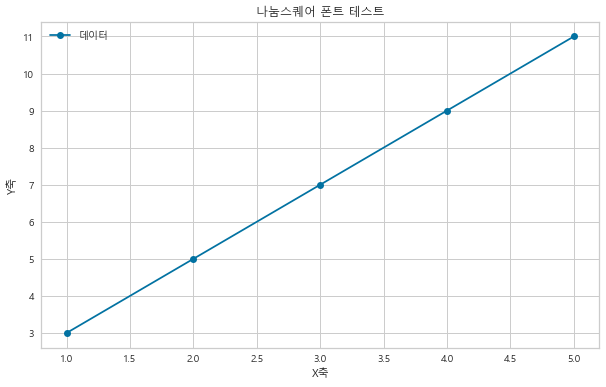

In [156]:
x = [1, 2, 3, 4, 5]
y = [3, 5, 7, 9, 11]

plt.figure(figsize=(10,6))
plt.plot(x, y, 'o-', label="데이터")
plt.title("나눔스퀘어 폰트 테스트")
plt.xlabel("X축")
plt.ylabel("Y축")
plt.legend()
plt.show()

In [157]:
raw_file = "./data/purchase_transaction_data.csv"
raw = pd.read_csv(raw_file)
raw[['Category1', 'Category2', 'Category3', 'Category4', 'Category5']] = raw['MasterCategoryFullName'].str.split('-', expand=True)
raw.loc[(raw['Category1'] == '주류') & (raw['Category2'] == ''), 'Category2'] = '주류'
raw["Sales"] = raw["Price"] * raw["SalesUnit"]
raw

,id,OrderId,PersonId,PurchaseDate,ItemDescription,SalesUnit,Price,ProductCode,MasterCategoryFullName,Agegroup,Gender,Retailer,Category1,Category2,Category3,Category4,Category5,Sales
0,2,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,대림 오양맛살270g,1,1480,8801088106118,가공식품-어육/연식품류-어육제품류-맛살,36,F,A,가공식품,어육/연식품류,어육제품류,맛살,None,1480
1,8,2021010108138430000000,168586e3815732f18f68ddef204819c7,2021-01-01,풀무원 김치뚝배기 우동 (2인),1,6180,8801114147252,가공식품-즉석/편의식품-즉석/조리식품-즉석면류,36,M,B,가공식품,즉석/편의식품,즉석/조리식품,즉석면류,None,6180
2,9,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,CJ백설소갈비양념500g,1,2580,8801007176352,가공식품-조미료-드레싱/소스-소스,36,F,A,가공식품,조미료,드레싱/소스,소스,None,2580
3,11,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,샘표맛간장조림볶음용,2,8880,8801005104067,가공식품-조미료-장류-간장,36,F,A,가공식품,조미료,장류,간장,None,17760
4,13,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,샘표맛간장국찌개1.8L,1,8900,8801005110228,가공식품-조미료-장류-간장,36,F,A,가공식품,조미료,장류,간장,None,8900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118804,390581,2021040306718280000000,eea4022e52f88e47e002bf9533aded5c,2021-04-03,빙그레 요플레 클래식,1,2800,8801104280037,가공식품-유제품-요구르트-기타요구르트,40,F,A,가공식품,유제품,요구르트,기타요구르트,None,2800
118805,390584,2021022700263890000000,eea4022e52f88e47e002bf9533aded5c,2021-02-27,풀무원 자연은맛있다,1,4980,8801114150450,가공식품-즉석/편의식품-라면류-봉지라면,40,F,A,가공식품,즉석/편의식품,라면류,봉지라면,None,4980
118806,390586,2023062500967460000000,22aca1bdf92346d1fbd589fd72622957,2023-06-25,딸기잼800g,1,5880,8809306211033,가공식품-통조림/병-농산물통조림/병-잼류/스프레드류,44,M,A,가공식품,통조림/병,농산물통조림/병,잼류/스프레드류,None,5880
118807,390588,2023062905029460000000,5957cbf9d746b210eedc703ea368a00e,2023-06-29,왓따산리오캐릭터즈13,2,500,8801062874781,가공식품-과자류-사탕류-껌류,36,F,A,가공식품,과자류,사탕류,껌류,None,1000


#### 성별

In [163]:
GP_group = raw.groupby(["Gender"])["PersonId"].nunique()
GP_group

Gender
F    1947
M     729
Name: PersonId, dtype: int64

In [164]:
GO_group = raw.groupby(["Gender"])["OrderId"].nunique()
GO_group

Gender
F    21826
M     9724
Name: OrderId, dtype: int64

In [183]:
GS_group = raw.groupby(["Gender"])["Sales"].sum()
GS_group = np.round(GS_group/10000, 2)
GS_group

Gender
F    42216.3
M    19874.9
Name: Sales, dtype: float64

In [184]:
OS_group = raw.groupby(["OrderId", "Gender"])["Sales"].sum()
OS_mean = OS_group.groupby(["Gender"]).mean()
OS_mean = np.round(OS_mean/10000, 2)
OS_mean

Gender
F    1.93
M    2.04
Name: Sales, dtype: float64

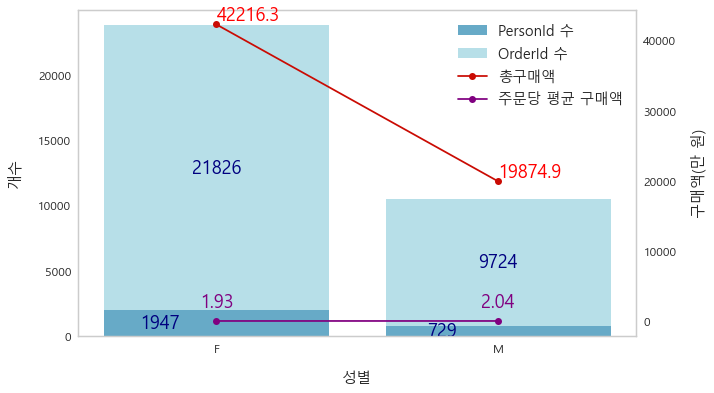

In [228]:
# 데이터를 설정합니다.
gender_labels = GP_group.index

# 첫 번째 y축에 대한 데이터를 설정합니다.
y1_data1 = GP_group.values
y1_data2 = GO_group.values

# 두 번째 y축에 대한 데이터를 설정합니다.
y2_data1 = GS_group.values
y2_data2 = OS_mean.values

# 첫 번째 y축 그래프를 그립니다.
fig, ax1 = plt.subplots(figsize=(10, 6))
bars1 = ax1.bar(gender_labels, y1_data1, label="PersonId 수", color="b", alpha=0.6)
bars2 = ax1.bar(gender_labels, y1_data2, label="OrderId 수", color="c", alpha=0.6, bottom=y1_data1) # 누적 바 차트로 표현
ax1.set_ylabel('개수', fontsize = 15, labelpad = 15)
ax1.set_xlabel('성별', fontsize = 15, labelpad = 15)
ax1.tick_params(axis='both', labelsize=12)
ax1.grid(False)

# 두 번째 y축 그래프를 그립니다.
ax2 = ax1.twinx()
line1, = ax2.plot(gender_labels, y2_data1, label="총구매액", color="r", marker='o')
line2, = ax2.plot(gender_labels, y2_data2, label="주문당 평균 구매액", color="purple", marker='o')
ax2.set_ylabel('구매액(만 원)', fontsize = 15, labelpad = 15)
ax2.tick_params(axis='both', labelsize=12)
ax2.grid(False)

# 범례를 합치기 위해 핸들과 레이블을 가져옵니다.
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right', fontsize='large', facecolor = 'white') # 위치와 폰트 크기 조절

# 첫 번째 y축 그래프에 수치를 추가합니다.
for idx, rect in enumerate(bars1):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2. - 0.2, height / 2.,
             '%d' % int(height),
             ha='center', va='center', fontsize=18, color='navy')
for idx, rect in enumerate(bars2):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2., y1_data1[idx] + height / 2.,
             '%d' % int(height),
             ha='center', va='center', fontsize=18, color='navy')

# 두 번째 y축 그래프에 수치를 추가합니다.
for i, txt in enumerate(y2_data1):
    ax2.text(i, txt, str(txt), ha='left', va='bottom', fontsize=18, color='red')
for i, txt in enumerate(y2_data2):
    ax2.text(i, txt+4000, str(txt), ha='center', va='top', fontsize=18, color='purple')

plt.show()

#### 연령별

In [229]:
age_dic = {
            23 : "23세 이하", 
            24 : "24-27",
            28 : "28-31",
            32 : "32-35",
            36 : "36-39",
            40 : "40-43",
            44 : "44-47",
            48 : "48-51",
            52 : "52-55",
            56 : "56-59",
            60 : "60-63",
            64 : "64세 이상",
            65 : "64세 이상",
}
# Agegroup 컬럼의 값을 age_dic 딕셔너리를 참조하여 대체
raw['Agegroup'] = raw['Agegroup'].replace(age_dic)
raw

,id,OrderId,PersonId,PurchaseDate,ItemDescription,SalesUnit,Price,ProductCode,MasterCategoryFullName,Agegroup,Gender,Retailer,Category1,Category2,Category3,Category4,Category5,Sales
0,2,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,대림 오양맛살270g,1,1480,8801088106118,가공식품-어육/연식품류-어육제품류-맛살,36-39,F,A,가공식품,어육/연식품류,어육제품류,맛살,None,1480
1,8,2021010108138430000000,168586e3815732f18f68ddef204819c7,2021-01-01,풀무원 김치뚝배기 우동 (2인),1,6180,8801114147252,가공식품-즉석/편의식품-즉석/조리식품-즉석면류,36-39,M,B,가공식품,즉석/편의식품,즉석/조리식품,즉석면류,None,6180
2,9,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,CJ백설소갈비양념500g,1,2580,8801007176352,가공식품-조미료-드레싱/소스-소스,36-39,F,A,가공식품,조미료,드레싱/소스,소스,None,2580
3,11,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,샘표맛간장조림볶음용,2,8880,8801005104067,가공식품-조미료-장류-간장,36-39,F,A,가공식품,조미료,장류,간장,None,17760
4,13,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,샘표맛간장국찌개1.8L,1,8900,8801005110228,가공식품-조미료-장류-간장,36-39,F,A,가공식품,조미료,장류,간장,None,8900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118804,390581,2021040306718280000000,eea4022e52f88e47e002bf9533aded5c,2021-04-03,빙그레 요플레 클래식,1,2800,8801104280037,가공식품-유제품-요구르트-기타요구르트,40-43,F,A,가공식품,유제품,요구르트,기타요구르트,None,2800
118805,390584,2021022700263890000000,eea4022e52f88e47e002bf9533aded5c,2021-02-27,풀무원 자연은맛있다,1,4980,8801114150450,가공식품-즉석/편의식품-라면류-봉지라면,40-43,F,A,가공식품,즉석/편의식품,라면류,봉지라면,None,4980
118806,390586,2023062500967460000000,22aca1bdf92346d1fbd589fd72622957,2023-06-25,딸기잼800g,1,5880,8809306211033,가공식품-통조림/병-농산물통조림/병-잼류/스프레드류,44-47,M,A,가공식품,통조림/병,농산물통조림/병,잼류/스프레드류,None,5880
118807,390588,2023062905029460000000,5957cbf9d746b210eedc703ea368a00e,2023-06-29,왓따산리오캐릭터즈13,2,500,8801062874781,가공식품-과자류-사탕류-껌류,36-39,F,A,가공식품,과자류,사탕류,껌류,None,1000


In [261]:
AP_group = raw.groupby(["Agegroup"])["PersonId"].nunique()
AP_group

Agegroup
23세 이하     16
24-27      55
28-31     223
32-35     331
36-39     514
40-43     543
44-47     403
48-51     266
52-55     161
56-59      66
60-63      46
64세 이상     52
Name: PersonId, dtype: int64

In [262]:
AO_group = raw.groupby(["Agegroup"])["OrderId"].nunique()
AO_group

Agegroup
23세 이하     100
24-27      479
28-31     1530
32-35     3208
36-39     4769
40-43     7069
44-47     4978
48-51     4704
52-55     2756
56-59     1095
60-63      444
64세 이상     418
Name: OrderId, dtype: int64

In [266]:
AS_group = raw.groupby(["Agegroup"])["Sales"].sum()
AS_group = np.round(AS_group/10000, 2)
AS_group

Agegroup
23세 이하      143.67
24-27       791.89
28-31      2278.64
32-35      6444.06
36-39      9088.77
40-43     15108.81
44-47      9814.31
48-51      9861.51
52-55      5131.11
56-59      2181.56
60-63       691.40
64세 이상      555.46
Name: Sales, dtype: float64

In [267]:
OS_group = raw.groupby(["OrderId", "Agegroup"])["Sales"].sum()
OS_mean = OS_group.groupby(["Agegroup"]).mean()
OS_mean = np.round(OS_mean, 2)
OS_mean

Agegroup
23세 이하    14367.30
24-27     16532.18
28-31     14893.06
32-35     20087.48
36-39     19058.01
40-43     21373.33
44-47     19715.37
48-51     20964.10
52-55     18617.95
56-59     19922.88
60-63     15572.07
64세 이상    13288.61
Name: Sales, dtype: float64

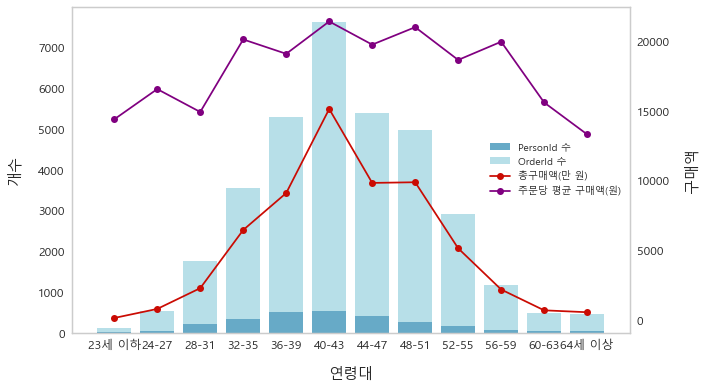

In [271]:
# 데이터를 설정합니다.
age_labels = AP_group.index

# 첫 번째 y축에 대한 데이터를 설정합니다.
y1_data1 = AP_group.values
y1_data2 = AO_group.values

# 두 번째 y축에 대한 데이터를 설정합니다.
y2_data1 = AS_group.values
y2_data2 = OS_mean.values

# 첫 번째 y축 그래프를 그립니다.
fig, ax1 = plt.subplots(figsize=(10, 6))
bars1 = ax1.bar(age_labels, y1_data1, label="PersonId 수", color="b", alpha=0.6)
bars2 = ax1.bar(age_labels, y1_data2, label="OrderId 수", color="c", alpha=0.6, bottom=y1_data1) # 누적 바 차트로 표현
ax1.set_ylabel('개수', fontsize = 15, labelpad = 15)
ax1.set_xlabel('연령대', fontsize = 15, labelpad = 15)
ax1.tick_params(axis='both', labelsize=12)
ax1.grid(False)

# 두 번째 y축 그래프를 그립니다.
ax2 = ax1.twinx()
line1, = ax2.plot(age_labels, y2_data1, label="총구매액(만 원)", color="r", marker='o')
line2, = ax2.plot(age_labels, y2_data2, label="주문당 평균 구매액(원)", color="purple", marker='o')
ax2.set_ylabel('구매액', fontsize = 15, labelpad = 15)
ax2.tick_params(axis='both', labelsize=12)
ax2.grid(False)

# 범례를 합치기 위해 핸들과 레이블을 가져옵니다.
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center right', fontsize='small', facecolor = 'white') # 위치와 폰트 크기 조절

# # 첫 번째 y축 그래프에 수치를 추가합니다.
# for idx, rect in enumerate(bars1):
#     height = rect.get_height()
#     ax1.text(rect.get_x() + rect.get_width() / 2. - 0.2, height / 2.,
#              '%d' % int(height),
#              ha='center', va='center', fontsize=18, color='navy')
# for idx, rect in enumerate(bars2):
#     height = rect.get_height()
#     ax1.text(rect.get_x() + rect.get_width() / 2., y1_data1[idx] + height / 2.,
#              '%d' % int(height),
#              ha='center', va='center', fontsize=18, color='navy')

# # 두 번째 y축 그래프에 수치를 추가합니다.
# for i, txt in enumerate(y2_data1):
#     ax2.text(i, txt, str(txt), ha='left', va='bottom', fontsize=18, color='red')
# for i, txt in enumerate(y2_data2):
#     ax2.text(i, txt+4000, str(txt), ha='center', va='top', fontsize=18, color='purple')

plt.show()